In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import concatenate
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical


In [2]:
#DataSet
#https://drive.google.com/drive/folders/149M1URjyKgyveT3u8DM4JLUYwZlz7LB8
#https://drive.google.com/file/d/16fhpvfUQ2AAAavkIU4v6bMRZN3SNnQH6/view

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/NLP/Flickr.zip -d /content/drive/MyDrive/NLP/flickr8k/

In [ ]:
!ls /content/drive/MyDrive/NLP/flickr8k/Flickr8k_text/Flickr8k.token.txt

ls: cannot access '/content/drive/MyDrive/NLP/flickr8k/Flickr8k_text/Flickr8k.token.txt': No such file or directory


In [ ]:
ls /content/drive/MyDrive/NLP/flickr8k/Flickr8k_Dataset/

In [ ]:
#https://www.kaggle.com/incorpes/glove6b200d

In [ ]:
token_path = '/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_text/Flickr8k.token.txt'
train_images_path = '/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_Dataset/'
glove_path = '/content/drive/MyDrive/NLP_Batch21/'
doc = open(token_path,'r').read()
print(doc[:410])


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:
!ls /content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_text/

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt  Flickr_8k.trainImages.txt
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  readme.txt
Flickr_8k.devImages.txt     Flickr8k.token.txt


In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [ ]:
desc_list

['a man in a pink shirt climbs a rock face',
 'a man is rock climbing high in the air ',
 'a person in a red shirt climbing up a rock face covered in assist handles ',
 'a rock climber in a red shirt ',
 'a rock climber practices on a rock climbing wall ']

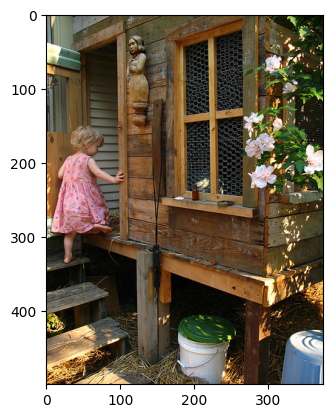

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [ ]:
len(descriptions)

8092

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
new_descriptions

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way \n1000268201_693b08cb0e a girl going into a wooden building \n1000268201_693b08cb0e a little girl climbing into a wooden playhouse \n1000268201_693b08cb0e a little girl climbing the stairs to her playhouse \n1000268201_693b08cb0e a little girl in a pink dress going into a wooden cabin \n1001773457_577c3a7d70 a black dog and a spotted dog are fighting\n1001773457_577c3a7d70 a black dog and a tricolored dog playing with each other on the road \n1001773457_577c3a7d70 a black dog and a white dog with brown spots are staring at each other in the street \n1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road \n1001773457_577c3a7d70 two dogs on pavement moving toward each other \n1002674143_1b742ab4b8 a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl \n1002674143_1b742ab4b8 a little girl is sitting in front of a large painted rai

In [ ]:
type(new_descriptions)

str

In [ ]:
len(descriptions.keys())

8092

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
len(train)

6000

In [ ]:
train

In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
    if i[len(images_path):] in test_images:
        test_img.append(i)

In [ ]:
train_img

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
len(all_train_captions)

30000

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
ixtoword

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices

In [ ]:
len(embeddings_index['cat'])

300

In [ ]:
vocab_size

1660

In [ ]:
np.zeros((vocab_size, 300)).shape

(1660, 300)

In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      print(word, " is Not There")


startseq  is Not There
endseq  is Not There
snowcovered  is Not There
tshirt  is Not There
waterskier  is Not There
floaties  is Not There
upsidedown  is Not There
merrygoround  is Not There
rollerblader  is Not There


In [ ]:
embedding_matrix.shape

(1660, 300)

In [ ]:
len(embedding_matrix[0])

300

In [ ]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 4s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)


In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
preprocess('/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_Dataset/3608567609_aae96d4a5e.jpg').shape

(1, 299, 299, 3)

In [ ]:
model_new.predict(preprocess('/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_Dataset/3608567609_aae96d4a5e.jpg')).shape

1/1 [==============================] - 0s 234ms/step


(1, 2048)

In [ ]:
# '/content/drive/MyDrive/NLP_Batch21/flickr8k/Flickr8k_Dataset/3608567609_aae96d4a5e.jpg'

In [ ]:
from tqdm import tqdm

def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images_path):]] = encode(img)

1/1 [==============================] - 0s 166ms/step


  9%|▉         | 528/6000 [08:37<1:36:25,  1.06s/it]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 529/6000 [08:38<1:32:17,  1.01s/it]

1/1 [==============================] - 0s 169ms/step


  9%|▉         | 530/6000 [08:39<1:34:28,  1.04s/it]

1/1 [==============================] - 0s 169ms/step


  9%|▉         | 531/6000 [08:40<1:31:06,  1.00it/s]

1/1 [==============================] - 0s 166ms/step


  9%|▉         | 532/6000 [08:41<1:25:30,  1.07it/s]

1/1 [==============================] - 0s 228ms/step


  9%|▉         | 533/6000 [08:42<1:25:52,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


  9%|▉         | 534/6000 [08:43<1:29:21,  1.02it/s]

1/1 [==============================] - 0s 158ms/step


  9%|▉         | 535/6000 [08:44<1:32:16,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 536/6000 [08:45<1:33:24,  1.03s/it]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 537/6000 [08:46<1:33:52,  1.03s/it]

1/1 [==============================] - 0s 164ms/step


  9%|▉         | 538/6000 [08:47<1:35:06,  1.04s/it]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 539/6000 [08:48<1:26:14,  1.06it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 540/6000 [08:48<1:22:50,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 541/6000 [08:49<1:21:47,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 542/6000 [08:50<1:22:40,  1.10it/s]

1/1 [==============================] - 0s 165ms/step


  9%|▉         | 543/6000 [08:51<1:21:48,  1.11it/s]

1/1 [==============================] - 0s 165ms/step


  9%|▉         | 544/6000 [08:52<1:18:00,  1.17it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 545/6000 [08:53<1:23:16,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 546/6000 [08:54<1:21:46,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 547/6000 [08:57<2:17:21,  1.51s/it]

1/1 [==============================] - 0s 160ms/step


  9%|▉         | 548/6000 [08:58<2:03:56,  1.36s/it]

1/1 [==============================] - 0s 163ms/step


  9%|▉         | 549/6000 [08:59<1:50:44,  1.22s/it]

1/1 [==============================] - 0s 170ms/step


  9%|▉         | 550/6000 [08:59<1:40:36,  1.11s/it]

1/1 [==============================] - 0s 166ms/step


  9%|▉         | 551/6000 [09:00<1:36:24,  1.06s/it]

1/1 [==============================] - 0s 170ms/step


  9%|▉         | 552/6000 [09:01<1:30:28,  1.00it/s]

1/1 [==============================] - 0s 170ms/step


  9%|▉         | 553/6000 [09:02<1:34:33,  1.04s/it]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 554/6000 [09:03<1:34:44,  1.04s/it]

1/1 [==============================] - 0s 236ms/step


  9%|▉         | 555/6000 [09:04<1:33:00,  1.02s/it]

1/1 [==============================] - 0s 171ms/step


  9%|▉         | 556/6000 [09:05<1:30:17,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


  9%|▉         | 557/6000 [09:06<1:26:48,  1.05it/s]

1/1 [==============================] - 0s 170ms/step


  9%|▉         | 558/6000 [09:07<1:27:20,  1.04it/s]

1/1 [==============================] - 0s 159ms/step


  9%|▉         | 559/6000 [09:08<1:25:17,  1.06it/s]

1/1 [==============================] - 0s 171ms/step


  9%|▉         | 560/6000 [09:09<1:26:44,  1.05it/s]

1/1 [==============================] - 0s 168ms/step


  9%|▉         | 561/6000 [09:10<1:22:03,  1.10it/s]

1/1 [==============================] - 0s 166ms/step


  9%|▉         | 562/6000 [09:11<1:20:24,  1.13it/s]

1/1 [==============================] - 0s 162ms/step


  9%|▉         | 563/6000 [09:12<1:24:25,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


  9%|▉         | 564/6000 [09:13<1:23:17,  1.09it/s]

1/1 [==============================] - 0s 171ms/step


  9%|▉         | 565/6000 [09:13<1:20:30,  1.13it/s]

1/1 [==============================] - 0s 164ms/step


  9%|▉         | 566/6000 [09:14<1:20:22,  1.13it/s]

1/1 [==============================] - 0s 231ms/step


  9%|▉         | 567/6000 [09:15<1:23:40,  1.08it/s]

1/1 [==============================] - 0s 174ms/step


  9%|▉         | 568/6000 [09:16<1:22:54,  1.09it/s]

1/1 [==============================] - 0s 163ms/step


  9%|▉         | 569/6000 [09:17<1:26:35,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 10%|▉         | 570/6000 [09:18<1:29:41,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 10%|▉         | 571/6000 [09:19<1:31:28,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 10%|▉         | 572/6000 [09:20<1:27:01,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 10%|▉         | 573/6000 [09:21<1:28:04,  1.03it/s]

1/1 [==============================] - 0s 172ms/step


 10%|▉         | 574/6000 [09:22<1:29:45,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 10%|▉         | 575/6000 [09:23<1:29:53,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 10%|▉         | 576/6000 [09:24<1:28:30,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 10%|▉         | 577/6000 [09:25<1:25:51,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 10%|▉         | 578/6000 [09:26<1:27:11,  1.04it/s]

1/1 [==============================] - 0s 236ms/step


 10%|▉         | 579/6000 [09:27<1:29:02,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 10%|▉         | 580/6000 [09:28<1:26:30,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 10%|▉         | 581/6000 [09:29<1:30:38,  1.00s/it]

1/1 [==============================] - 0s 162ms/step


 10%|▉         | 582/6000 [09:30<1:35:19,  1.06s/it]

1/1 [==============================] - 0s 159ms/step


 10%|▉         | 583/6000 [09:31<1:31:14,  1.01s/it]

1/1 [==============================] - 0s 167ms/step


 10%|▉         | 584/6000 [09:32<1:23:47,  1.08it/s]

1/1 [==============================] - 0s 174ms/step


 10%|▉         | 585/6000 [09:33<1:23:58,  1.07it/s]

1/1 [==============================] - 0s 174ms/step


 10%|▉         | 586/6000 [09:34<1:23:24,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 10%|▉         | 587/6000 [09:35<1:21:54,  1.10it/s]

1/1 [==============================] - 0s 165ms/step


 10%|▉         | 588/6000 [09:35<1:17:30,  1.16it/s]

1/1 [==============================] - 0s 166ms/step


 10%|▉         | 589/6000 [09:37<1:24:39,  1.07it/s]

1/1 [==============================] - 0s 253ms/step


 10%|▉         | 590/6000 [09:38<1:33:40,  1.04s/it]

1/1 [==============================] - 0s 235ms/step


 10%|▉         | 591/6000 [09:39<1:33:45,  1.04s/it]

1/1 [==============================] - 0s 164ms/step


 10%|▉         | 592/6000 [09:40<1:30:15,  1.00s/it]

1/1 [==============================] - 0s 159ms/step


 10%|▉         | 593/6000 [09:41<1:30:57,  1.01s/it]

1/1 [==============================] - 0s 157ms/step


 10%|▉         | 594/6000 [09:42<1:26:24,  1.04it/s]

1/1 [==============================] - 0s 166ms/step


 10%|▉         | 595/6000 [09:43<1:32:42,  1.03s/it]

1/1 [==============================] - 0s 167ms/step


 10%|▉         | 596/6000 [09:44<1:29:28,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 10%|▉         | 597/6000 [09:45<1:26:51,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 10%|▉         | 598/6000 [09:46<1:29:00,  1.01it/s]

1/1 [==============================] - 0s 166ms/step


 10%|▉         | 599/6000 [09:47<1:32:48,  1.03s/it]

1/1 [==============================] - 0s 159ms/step


 10%|█         | 600/6000 [09:48<1:28:47,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 10%|█         | 601/6000 [09:49<1:26:40,  1.04it/s]

1/1 [==============================] - 0s 241ms/step


 10%|█         | 602/6000 [09:50<1:33:27,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 10%|█         | 603/6000 [09:51<1:31:44,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 10%|█         | 604/6000 [09:52<1:23:42,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 605/6000 [09:52<1:17:54,  1.15it/s]

1/1 [==============================] - 0s 168ms/step


 10%|█         | 606/6000 [09:53<1:19:27,  1.13it/s]

1/1 [==============================] - 0s 169ms/step


 10%|█         | 607/6000 [09:54<1:19:09,  1.14it/s]

1/1 [==============================] - 0s 166ms/step


 10%|█         | 608/6000 [09:55<1:24:17,  1.07it/s]

1/1 [==============================] - 0s 172ms/step


 10%|█         | 609/6000 [09:56<1:33:45,  1.04s/it]

1/1 [==============================] - 0s 165ms/step


 10%|█         | 610/6000 [09:57<1:31:17,  1.02s/it]

1/1 [==============================] - 0s 169ms/step


 10%|█         | 611/6000 [09:58<1:27:07,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 10%|█         | 612/6000 [09:59<1:24:39,  1.06it/s]

1/1 [==============================] - 0s 169ms/step


 10%|█         | 613/6000 [10:00<1:23:34,  1.07it/s]

1/1 [==============================] - 0s 237ms/step


 10%|█         | 614/6000 [10:01<1:24:37,  1.06it/s]

1/1 [==============================] - 0s 170ms/step


 10%|█         | 615/6000 [10:02<1:24:17,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 10%|█         | 616/6000 [10:03<1:32:21,  1.03s/it]

1/1 [==============================] - 0s 163ms/step


 10%|█         | 617/6000 [10:04<1:30:48,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 10%|█         | 618/6000 [10:05<1:26:17,  1.04it/s]

1/1 [==============================] - 0s 159ms/step


 10%|█         | 619/6000 [10:06<1:20:05,  1.12it/s]

1/1 [==============================] - 0s 159ms/step


 10%|█         | 620/6000 [10:07<1:23:27,  1.07it/s]

1/1 [==============================] - 0s 176ms/step


 10%|█         | 621/6000 [10:08<1:23:19,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 622/6000 [10:09<1:28:35,  1.01it/s]

1/1 [==============================] - 0s 160ms/step


 10%|█         | 623/6000 [10:10<1:29:33,  1.00it/s]

1/1 [==============================] - 0s 167ms/step


 10%|█         | 624/6000 [10:11<1:30:15,  1.01s/it]

1/1 [==============================] - 0s 235ms/step


 10%|█         | 625/6000 [10:12<1:33:34,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 10%|█         | 626/6000 [10:13<1:31:01,  1.02s/it]

1/1 [==============================] - 0s 166ms/step


 10%|█         | 627/6000 [10:14<1:27:08,  1.03it/s]

1/1 [==============================] - 0s 161ms/step


 10%|█         | 628/6000 [10:15<1:23:29,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


 10%|█         | 629/6000 [10:16<1:28:17,  1.01it/s]

1/1 [==============================] - 0s 170ms/step


 10%|█         | 630/6000 [10:17<1:24:33,  1.06it/s]

1/1 [==============================] - 0s 161ms/step


 11%|█         | 631/6000 [10:17<1:21:03,  1.10it/s]

1/1 [==============================] - 0s 161ms/step


 11%|█         | 632/6000 [10:18<1:19:37,  1.12it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 633/6000 [10:19<1:25:20,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 634/6000 [10:20<1:18:45,  1.14it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█         | 635/6000 [10:21<1:22:09,  1.09it/s]

1/1 [==============================] - 0s 164ms/step


 11%|█         | 636/6000 [10:22<1:24:17,  1.06it/s]

1/1 [==============================] - 0s 233ms/step


 11%|█         | 637/6000 [10:23<1:22:52,  1.08it/s]

1/1 [==============================] - 0s 233ms/step


 11%|█         | 638/6000 [10:24<1:27:35,  1.02it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 639/6000 [10:25<1:33:23,  1.05s/it]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 640/6000 [10:26<1:28:53,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


 11%|█         | 641/6000 [10:27<1:22:13,  1.09it/s]

1/1 [==============================] - 0s 175ms/step


 11%|█         | 642/6000 [10:28<1:21:10,  1.10it/s]

1/1 [==============================] - 0s 167ms/step


 11%|█         | 643/6000 [10:29<1:24:42,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 11%|█         | 644/6000 [10:30<1:25:04,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 645/6000 [10:31<1:25:49,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 11%|█         | 646/6000 [10:32<1:22:30,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 647/6000 [10:33<1:25:55,  1.04it/s]

1/1 [==============================] - 0s 170ms/step


 11%|█         | 648/6000 [10:34<1:29:22,  1.00s/it]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 649/6000 [10:35<1:30:25,  1.01s/it]

1/1 [==============================] - 0s 157ms/step


 11%|█         | 650/6000 [10:36<1:40:36,  1.13s/it]

1/1 [==============================] - 0s 162ms/step


 11%|█         | 651/6000 [10:37<1:34:37,  1.06s/it]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 652/6000 [10:38<1:34:15,  1.06s/it]

1/1 [==============================] - 0s 176ms/step


 11%|█         | 653/6000 [10:39<1:29:38,  1.01s/it]

1/1 [==============================] - 0s 169ms/step


 11%|█         | 654/6000 [10:40<1:28:34,  1.01it/s]

1/1 [==============================] - 0s 164ms/step


 11%|█         | 655/6000 [10:41<1:24:20,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█         | 656/6000 [10:42<1:26:22,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 11%|█         | 657/6000 [10:43<1:27:34,  1.02it/s]

1/1 [==============================] - 0s 159ms/step


 11%|█         | 658/6000 [10:44<1:24:15,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█         | 659/6000 [10:45<1:23:18,  1.07it/s]

1/1 [==============================] - 0s 184ms/step


 11%|█         | 660/6000 [10:46<1:22:03,  1.08it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 661/6000 [10:46<1:21:43,  1.09it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█         | 662/6000 [10:47<1:17:24,  1.15it/s]

1/1 [==============================] - 0s 170ms/step


 11%|█         | 663/6000 [10:48<1:22:33,  1.08it/s]

1/1 [==============================] - 0s 171ms/step


 11%|█         | 664/6000 [10:49<1:20:16,  1.11it/s]

1/1 [==============================] - 0s 168ms/step


 11%|█         | 665/6000 [10:50<1:23:49,  1.06it/s]

1/1 [==============================] - 0s 174ms/step


 11%|█         | 666/6000 [10:51<1:22:42,  1.07it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█         | 667/6000 [10:52<1:26:15,  1.03it/s]

1/1 [==============================] - 0s 160ms/step


 11%|█         | 668/6000 [10:53<1:23:06,  1.07it/s]

1/1 [==============================] - 0s 163ms/step


 11%|█         | 669/6000 [10:54<1:20:50,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 11%|█         | 670/6000 [10:55<1:20:19,  1.11it/s]

1/1 [==============================] - 0s 162ms/step


 11%|█         | 671/6000 [10:56<1:19:28,  1.12it/s]

1/1 [==============================] - 0s 158ms/step


 11%|█         | 672/6000 [10:56<1:18:14,  1.13it/s]

1/1 [==============================] - 0s 244ms/step


 11%|█         | 673/6000 [10:57<1:21:59,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 11%|█         | 674/6000 [10:58<1:22:50,  1.07it/s]

1/1 [==============================] - 0s 171ms/step


 11%|█▏        | 675/6000 [10:59<1:21:48,  1.08it/s]

1/1 [==============================] - 0s 165ms/step


 11%|█▏        | 676/6000 [11:00<1:25:33,  1.04it/s]

1/1 [==============================] - 0s 169ms/step


 11%|█▏        | 677/6000 [11:01<1:18:47,  1.13it/s]

1/1 [==============================] - 0s 169ms/step


 11%|█▏        | 678/6000 [11:02<1:25:14,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 11%|█▏        | 679/6000 [11:03<1:26:55,  1.02it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█▏        | 680/6000 [11:04<1:23:37,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 11%|█▏        | 681/6000 [11:05<1:27:57,  1.01it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█▏        | 682/6000 [11:06<1:26:01,  1.03it/s]

1/1 [==============================] - 0s 169ms/step


 11%|█▏        | 683/6000 [11:07<1:24:52,  1.04it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█▏        | 684/6000 [11:08<1:24:23,  1.05it/s]

1/1 [==============================] - 0s 285ms/step


 11%|█▏        | 685/6000 [11:09<1:26:00,  1.03it/s]

1/1 [==============================] - 0s 237ms/step


 11%|█▏        | 686/6000 [11:10<1:26:07,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 11%|█▏        | 687/6000 [11:11<1:28:08,  1.00it/s]

1/1 [==============================] - 0s 166ms/step


 11%|█▏        | 688/6000 [11:12<1:28:14,  1.00it/s]

1/1 [==============================] - 0s 160ms/step


 11%|█▏        | 689/6000 [11:13<1:25:17,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 12%|█▏        | 690/6000 [11:14<1:23:36,  1.06it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 691/6000 [11:15<1:22:27,  1.07it/s]

1/1 [==============================] - 0s 171ms/step


 12%|█▏        | 692/6000 [11:16<1:25:50,  1.03it/s]

1/1 [==============================] - 0s 175ms/step


 12%|█▏        | 693/6000 [11:17<1:28:27,  1.00s/it]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 694/6000 [11:18<1:25:50,  1.03it/s]

1/1 [==============================] - 0s 171ms/step


 12%|█▏        | 695/6000 [11:19<1:27:19,  1.01it/s]

1/1 [==============================] - 0s 171ms/step


 12%|█▏        | 696/6000 [11:20<1:23:41,  1.06it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 697/6000 [11:21<1:27:58,  1.00it/s]

1/1 [==============================] - 0s 171ms/step


 12%|█▏        | 698/6000 [11:22<1:30:11,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 12%|█▏        | 699/6000 [11:23<1:41:36,  1.15s/it]

1/1 [==============================] - 0s 168ms/step


 12%|█▏        | 700/6000 [11:24<1:34:59,  1.08s/it]

1/1 [==============================] - 0s 169ms/step


 12%|█▏        | 701/6000 [11:25<1:30:59,  1.03s/it]

1/1 [==============================] - 0s 169ms/step


 12%|█▏        | 702/6000 [11:26<1:28:40,  1.00s/it]

1/1 [==============================] - 0s 167ms/step


 12%|█▏        | 703/6000 [11:27<1:29:45,  1.02s/it]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 704/6000 [11:28<1:23:03,  1.06it/s]

1/1 [==============================] - 0s 173ms/step


 12%|█▏        | 705/6000 [11:29<1:25:23,  1.03it/s]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 706/6000 [11:30<1:28:28,  1.00s/it]

1/1 [==============================] - 0s 164ms/step


 12%|█▏        | 707/6000 [11:31<1:21:18,  1.09it/s]

1/1 [==============================] - 0s 222ms/step


 12%|█▏        | 708/6000 [11:32<1:19:40,  1.11it/s]

1/1 [==============================] - 0s 235ms/step


 12%|█▏        | 709/6000 [11:32<1:16:33,  1.15it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█▏        | 710/6000 [11:33<1:19:11,  1.11it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█▏        | 711/6000 [11:34<1:19:12,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 12%|█▏        | 712/6000 [11:35<1:19:26,  1.11it/s]

1/1 [==============================] - 0s 168ms/step


 12%|█▏        | 713/6000 [11:36<1:19:53,  1.10it/s]

1/1 [==============================] - 0s 179ms/step


 12%|█▏        | 714/6000 [11:37<1:25:26,  1.03it/s]

1/1 [==============================] - 0s 183ms/step


 12%|█▏        | 715/6000 [11:38<1:26:18,  1.02it/s]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 716/6000 [11:39<1:27:59,  1.00it/s]

1/1 [==============================] - 0s 175ms/step


 12%|█▏        | 717/6000 [11:40<1:24:48,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 12%|█▏        | 718/6000 [11:41<1:20:00,  1.10it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█▏        | 719/6000 [11:42<1:23:40,  1.05it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 720/6000 [11:43<1:22:35,  1.07it/s]

1/1 [==============================] - 0s 226ms/step


 12%|█▏        | 721/6000 [11:44<1:24:55,  1.04it/s]

1/1 [==============================] - 0s 166ms/step


 12%|█▏        | 722/6000 [11:45<1:26:44,  1.01it/s]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 723/6000 [11:46<1:23:51,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 724/6000 [11:47<1:26:46,  1.01it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 725/6000 [11:48<1:28:34,  1.01s/it]

1/1 [==============================] - 0s 155ms/step


 12%|█▏        | 726/6000 [11:49<1:29:13,  1.02s/it]

1/1 [==============================] - 0s 166ms/step


 12%|█▏        | 727/6000 [11:50<1:21:29,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 12%|█▏        | 728/6000 [11:50<1:19:56,  1.10it/s]

1/1 [==============================] - 0s 171ms/step


 12%|█▏        | 729/6000 [11:51<1:17:04,  1.14it/s]

1/1 [==============================] - 0s 167ms/step


 12%|█▏        | 730/6000 [11:52<1:18:08,  1.12it/s]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 731/6000 [11:53<1:21:03,  1.08it/s]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 732/6000 [11:54<1:18:54,  1.11it/s]

1/1 [==============================] - 0s 246ms/step


 12%|█▏        | 733/6000 [11:55<1:16:46,  1.14it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█▏        | 734/6000 [11:56<1:18:25,  1.12it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█▏        | 735/6000 [11:57<1:19:53,  1.10it/s]

1/1 [==============================] - 0s 163ms/step


 12%|█▏        | 736/6000 [11:58<1:18:49,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 737/6000 [11:59<1:22:01,  1.07it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 738/6000 [12:00<1:22:46,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 12%|█▏        | 739/6000 [12:01<1:28:24,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 12%|█▏        | 740/6000 [12:02<1:25:31,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 12%|█▏        | 741/6000 [12:03<1:36:36,  1.10s/it]

1/1 [==============================] - 0s 160ms/step


 12%|█▏        | 742/6000 [12:04<1:27:41,  1.00s/it]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 743/6000 [12:05<1:32:46,  1.06s/it]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 744/6000 [12:06<1:32:47,  1.06s/it]

1/1 [==============================] - 0s 163ms/step


 12%|█▏        | 745/6000 [12:07<1:33:16,  1.06s/it]

1/1 [==============================] - 0s 173ms/step


 12%|█▏        | 746/6000 [12:08<1:29:08,  1.02s/it]

1/1 [==============================] - 0s 170ms/step


 12%|█▏        | 747/6000 [12:09<1:29:36,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 12%|█▏        | 748/6000 [12:10<1:25:24,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 12%|█▏        | 749/6000 [12:11<1:28:09,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 12%|█▎        | 750/6000 [12:12<1:28:26,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 751/6000 [12:13<1:30:25,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 752/6000 [12:14<1:30:15,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 753/6000 [12:15<1:29:01,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 754/6000 [12:16<1:22:09,  1.06it/s]

1/1 [==============================] - 0s 247ms/step


 13%|█▎        | 755/6000 [12:17<1:25:52,  1.02it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 756/6000 [12:18<1:26:27,  1.01it/s]

1/1 [==============================] - 0s 160ms/step


 13%|█▎        | 757/6000 [12:19<1:20:51,  1.08it/s]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 758/6000 [12:20<1:19:14,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 759/6000 [12:21<1:21:26,  1.07it/s]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 760/6000 [12:22<1:23:28,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 761/6000 [12:23<1:39:19,  1.14s/it]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 762/6000 [12:24<1:34:46,  1.09s/it]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 763/6000 [12:25<1:32:00,  1.05s/it]

1/1 [==============================] - 0s 168ms/step


 13%|█▎        | 764/6000 [12:26<1:31:10,  1.04s/it]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 765/6000 [12:27<1:30:52,  1.04s/it]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 766/6000 [12:28<1:28:19,  1.01s/it]

1/1 [==============================] - 0s 235ms/step


 13%|█▎        | 767/6000 [12:29<1:28:36,  1.02s/it]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 768/6000 [12:30<1:25:40,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 769/6000 [12:31<1:23:40,  1.04it/s]

1/1 [==============================] - 0s 169ms/step


 13%|█▎        | 770/6000 [12:32<1:22:25,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 771/6000 [12:33<1:29:14,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 772/6000 [12:34<1:26:13,  1.01it/s]

1/1 [==============================] - 0s 170ms/step


 13%|█▎        | 773/6000 [12:35<1:29:07,  1.02s/it]

1/1 [==============================] - 0s 172ms/step


 13%|█▎        | 774/6000 [12:36<1:25:07,  1.02it/s]

1/1 [==============================] - 0s 173ms/step


 13%|█▎        | 775/6000 [12:37<1:26:56,  1.00it/s]

1/1 [==============================] - 0s 171ms/step


 13%|█▎        | 776/6000 [12:38<1:25:23,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 777/6000 [12:39<1:21:39,  1.07it/s]

1/1 [==============================] - 0s 234ms/step


 13%|█▎        | 778/6000 [12:40<1:18:08,  1.11it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 779/6000 [12:41<1:22:17,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 780/6000 [12:42<1:23:58,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 781/6000 [12:43<1:25:56,  1.01it/s]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 782/6000 [12:44<1:28:45,  1.02s/it]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 783/6000 [12:45<1:26:47,  1.00it/s]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 784/6000 [12:46<1:28:46,  1.02s/it]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 785/6000 [12:47<1:25:49,  1.01it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 786/6000 [12:48<1:23:24,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 787/6000 [12:48<1:19:33,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 788/6000 [12:49<1:18:43,  1.10it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█▎        | 789/6000 [12:50<1:13:41,  1.18it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 790/6000 [12:51<1:19:23,  1.09it/s]

1/1 [==============================] - 0s 239ms/step


 13%|█▎        | 791/6000 [12:52<1:23:26,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 13%|█▎        | 792/6000 [12:53<1:25:05,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 793/6000 [12:54<1:19:21,  1.09it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 794/6000 [12:55<1:13:58,  1.17it/s]

1/1 [==============================] - 0s 170ms/step


 13%|█▎        | 795/6000 [12:56<1:17:38,  1.12it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█▎        | 796/6000 [12:57<1:24:22,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 797/6000 [12:58<1:29:45,  1.04s/it]

1/1 [==============================] - 0s 158ms/step


 13%|█▎        | 798/6000 [12:59<1:24:36,  1.02it/s]

1/1 [==============================] - 0s 166ms/step


 13%|█▎        | 799/6000 [13:00<1:18:42,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 13%|█▎        | 800/6000 [13:01<1:18:51,  1.10it/s]

1/1 [==============================] - 0s 173ms/step


 13%|█▎        | 801/6000 [13:01<1:16:28,  1.13it/s]

1/1 [==============================] - 0s 169ms/step


 13%|█▎        | 802/6000 [13:02<1:18:28,  1.10it/s]

1/1 [==============================] - 0s 237ms/step


 13%|█▎        | 803/6000 [13:03<1:19:36,  1.09it/s]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 804/6000 [13:04<1:17:06,  1.12it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 805/6000 [13:05<1:21:11,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 13%|█▎        | 806/6000 [13:06<1:22:21,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 13%|█▎        | 807/6000 [13:07<1:20:48,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 13%|█▎        | 808/6000 [13:08<1:30:41,  1.05s/it]

1/1 [==============================] - 0s 167ms/step


 13%|█▎        | 809/6000 [13:09<1:31:06,  1.05s/it]

1/1 [==============================] - 0s 162ms/step


 14%|█▎        | 810/6000 [13:10<1:31:11,  1.05s/it]

1/1 [==============================] - 0s 174ms/step


 14%|█▎        | 811/6000 [13:11<1:30:33,  1.05s/it]

1/1 [==============================] - 0s 165ms/step


 14%|█▎        | 812/6000 [13:12<1:28:59,  1.03s/it]

1/1 [==============================] - 0s 168ms/step


 14%|█▎        | 813/6000 [13:13<1:24:50,  1.02it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▎        | 814/6000 [13:14<1:24:28,  1.02it/s]

1/1 [==============================] - 0s 166ms/step


 14%|█▎        | 815/6000 [13:15<1:27:51,  1.02s/it]

1/1 [==============================] - 0s 168ms/step


 14%|█▎        | 816/6000 [13:16<1:23:12,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▎        | 817/6000 [13:17<1:20:35,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▎        | 818/6000 [13:18<1:19:29,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▎        | 819/6000 [13:19<1:17:36,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▎        | 820/6000 [13:20<1:23:31,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▎        | 821/6000 [13:21<1:23:49,  1.03it/s]

1/1 [==============================] - 0s 174ms/step


 14%|█▎        | 822/6000 [13:22<1:21:03,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▎        | 823/6000 [13:23<1:28:48,  1.03s/it]

1/1 [==============================] - 0s 167ms/step


 14%|█▎        | 824/6000 [13:24<1:20:59,  1.07it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▍        | 825/6000 [13:25<1:21:10,  1.06it/s]

1/1 [==============================] - 0s 234ms/step


 14%|█▍        | 826/6000 [13:26<1:24:24,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 827/6000 [13:27<1:17:34,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▍        | 828/6000 [13:28<1:20:53,  1.07it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 829/6000 [13:29<1:24:32,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▍        | 830/6000 [13:29<1:22:09,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 831/6000 [13:30<1:21:08,  1.06it/s]

1/1 [==============================] - 0s 168ms/step


 14%|█▍        | 832/6000 [13:31<1:22:03,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▍        | 833/6000 [13:32<1:20:41,  1.07it/s]

1/1 [==============================] - 0s 166ms/step


 14%|█▍        | 834/6000 [13:33<1:19:10,  1.09it/s]

1/1 [==============================] - 0s 169ms/step


 14%|█▍        | 835/6000 [13:34<1:22:43,  1.04it/s]

1/1 [==============================] - 0s 175ms/step


 14%|█▍        | 836/6000 [13:35<1:17:28,  1.11it/s]

1/1 [==============================] - 0s 169ms/step


 14%|█▍        | 837/6000 [13:36<1:22:03,  1.05it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 838/6000 [13:37<1:22:37,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 839/6000 [13:38<1:18:19,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 840/6000 [13:39<1:21:07,  1.06it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 841/6000 [13:40<1:15:44,  1.14it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 842/6000 [13:40<1:14:37,  1.15it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 843/6000 [13:41<1:15:09,  1.14it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 844/6000 [13:42<1:16:05,  1.13it/s]

1/1 [==============================] - 0s 174ms/step


 14%|█▍        | 845/6000 [13:43<1:19:34,  1.08it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▍        | 846/6000 [13:44<1:21:33,  1.05it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 847/6000 [13:45<1:19:17,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 848/6000 [13:46<1:20:43,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 14%|█▍        | 849/6000 [13:47<1:18:50,  1.09it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 850/6000 [13:48<1:20:22,  1.07it/s]

1/1 [==============================] - 0s 205ms/step


 14%|█▍        | 851/6000 [13:49<1:21:39,  1.05it/s]

1/1 [==============================] - 0s 168ms/step


 14%|█▍        | 852/6000 [13:50<1:21:05,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▍        | 853/6000 [13:51<1:15:10,  1.14it/s]

1/1 [==============================] - 0s 166ms/step


 14%|█▍        | 854/6000 [13:52<1:20:23,  1.07it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▍        | 855/6000 [13:53<1:23:08,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 14%|█▍        | 856/6000 [13:54<1:27:03,  1.02s/it]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 857/6000 [13:55<1:24:16,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 14%|█▍        | 858/6000 [13:56<1:24:44,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 14%|█▍        | 859/6000 [13:57<1:21:51,  1.05it/s]

1/1 [==============================] - 0s 169ms/step


 14%|█▍        | 860/6000 [13:57<1:16:10,  1.12it/s]

1/1 [==============================] - 0s 171ms/step


 14%|█▍        | 861/6000 [13:58<1:15:45,  1.13it/s]

1/1 [==============================] - 0s 229ms/step


 14%|█▍        | 862/6000 [13:59<1:20:47,  1.06it/s]

1/1 [==============================] - 0s 186ms/step


 14%|█▍        | 863/6000 [14:00<1:23:39,  1.02it/s]

1/1 [==============================] - 0s 169ms/step


 14%|█▍        | 864/6000 [14:01<1:21:25,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 14%|█▍        | 865/6000 [14:02<1:21:14,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 866/6000 [14:03<1:24:23,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 14%|█▍        | 867/6000 [14:04<1:21:37,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 14%|█▍        | 868/6000 [14:05<1:19:30,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 14%|█▍        | 869/6000 [14:06<1:13:50,  1.16it/s]

1/1 [==============================] - 0s 170ms/step


 14%|█▍        | 870/6000 [14:07<1:14:34,  1.15it/s]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 871/6000 [14:08<1:16:33,  1.12it/s]

1/1 [==============================] - 0s 235ms/step


 15%|█▍        | 872/6000 [14:08<1:17:05,  1.11it/s]

1/1 [==============================] - 0s 170ms/step


 15%|█▍        | 873/6000 [14:09<1:19:55,  1.07it/s]

1/1 [==============================] - 0s 244ms/step


 15%|█▍        | 874/6000 [14:10<1:20:51,  1.06it/s]

1/1 [==============================] - 0s 235ms/step


 15%|█▍        | 875/6000 [14:12<1:24:32,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 876/6000 [14:12<1:22:06,  1.04it/s]

1/1 [==============================] - 0s 158ms/step


 15%|█▍        | 877/6000 [14:13<1:18:52,  1.08it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▍        | 878/6000 [14:14<1:17:48,  1.10it/s]

1/1 [==============================] - 0s 161ms/step


 15%|█▍        | 879/6000 [14:15<1:19:42,  1.07it/s]

1/1 [==============================] - 0s 161ms/step


 15%|█▍        | 880/6000 [14:16<1:25:45,  1.00s/it]

1/1 [==============================] - 0s 161ms/step


 15%|█▍        | 881/6000 [14:17<1:23:18,  1.02it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▍        | 882/6000 [14:18<1:24:12,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 883/6000 [14:19<1:25:51,  1.01s/it]

1/1 [==============================] - 0s 160ms/step


 15%|█▍        | 884/6000 [14:20<1:26:11,  1.01s/it]

1/1 [==============================] - 0s 159ms/step


 15%|█▍        | 885/6000 [14:21<1:23:51,  1.02it/s]

1/1 [==============================] - 0s 172ms/step


 15%|█▍        | 886/6000 [14:23<1:48:37,  1.27s/it]

1/1 [==============================] - 0s 161ms/step


 15%|█▍        | 887/6000 [14:24<1:43:37,  1.22s/it]

1/1 [==============================] - 0s 164ms/step


 15%|█▍        | 888/6000 [14:25<1:42:44,  1.21s/it]

1/1 [==============================] - 0s 164ms/step


 15%|█▍        | 889/6000 [14:26<1:35:41,  1.12s/it]

1/1 [==============================] - 0s 161ms/step


 15%|█▍        | 890/6000 [14:27<1:32:00,  1.08s/it]

1/1 [==============================] - 0s 163ms/step


 15%|█▍        | 891/6000 [14:28<1:26:35,  1.02s/it]

1/1 [==============================] - 0s 168ms/step


 15%|█▍        | 892/6000 [14:29<1:26:01,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 15%|█▍        | 893/6000 [14:30<1:19:08,  1.08it/s]

1/1 [==============================] - 0s 169ms/step


 15%|█▍        | 894/6000 [14:31<1:17:23,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 895/6000 [14:32<1:17:35,  1.10it/s]

1/1 [==============================] - 0s 188ms/step


 15%|█▍        | 896/6000 [14:33<1:22:00,  1.04it/s]

1/1 [==============================] - 0s 228ms/step


 15%|█▍        | 897/6000 [14:34<1:17:27,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▍        | 898/6000 [14:35<1:17:11,  1.10it/s]

1/1 [==============================] - 0s 169ms/step


 15%|█▍        | 899/6000 [14:35<1:17:09,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 15%|█▌        | 900/6000 [14:38<1:53:06,  1.33s/it]

1/1 [==============================] - 0s 161ms/step


 15%|█▌        | 901/6000 [14:39<1:40:27,  1.18s/it]

1/1 [==============================] - 0s 165ms/step


 15%|█▌        | 902/6000 [14:40<1:36:52,  1.14s/it]

1/1 [==============================] - 0s 164ms/step


 15%|█▌        | 903/6000 [14:41<1:34:10,  1.11s/it]

1/1 [==============================] - 0s 161ms/step


 15%|█▌        | 904/6000 [14:42<1:31:39,  1.08s/it]

1/1 [==============================] - 0s 159ms/step


 15%|█▌        | 905/6000 [14:43<1:42:51,  1.21s/it]

1/1 [==============================] - 0s 204ms/step


 15%|█▌        | 906/6000 [14:44<1:37:35,  1.15s/it]

1/1 [==============================] - 0s 239ms/step


 15%|█▌        | 907/6000 [14:45<1:30:53,  1.07s/it]

1/1 [==============================] - 0s 161ms/step


 15%|█▌        | 908/6000 [14:46<1:24:28,  1.00it/s]

1/1 [==============================] - 0s 163ms/step


 15%|█▌        | 909/6000 [14:47<1:24:57,  1.00s/it]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 910/6000 [14:48<1:27:01,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 15%|█▌        | 911/6000 [14:49<1:23:17,  1.02it/s]

1/1 [==============================] - 0s 157ms/step


 15%|█▌        | 912/6000 [14:50<1:19:58,  1.06it/s]

1/1 [==============================] - 0s 160ms/step


 15%|█▌        | 913/6000 [14:51<1:17:38,  1.09it/s]

1/1 [==============================] - 0s 165ms/step


 15%|█▌        | 914/6000 [14:52<1:20:34,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 15%|█▌        | 915/6000 [14:53<1:22:26,  1.03it/s]

1/1 [==============================] - 0s 166ms/step


 15%|█▌        | 916/6000 [14:54<1:20:46,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 15%|█▌        | 917/6000 [14:54<1:19:16,  1.07it/s]

1/1 [==============================] - 0s 189ms/step


 15%|█▌        | 918/6000 [14:56<1:23:18,  1.02it/s]

1/1 [==============================] - 0s 222ms/step


 15%|█▌        | 919/6000 [14:56<1:18:16,  1.08it/s]

1/1 [==============================] - 0s 159ms/step


 15%|█▌        | 920/6000 [14:57<1:22:51,  1.02it/s]

1/1 [==============================] - 0s 174ms/step


 15%|█▌        | 921/6000 [14:58<1:21:38,  1.04it/s]

1/1 [==============================] - 0s 170ms/step


 15%|█▌        | 922/6000 [14:59<1:23:58,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 15%|█▌        | 923/6000 [15:00<1:19:35,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 15%|█▌        | 924/6000 [15:01<1:17:55,  1.09it/s]

1/1 [==============================] - 0s 171ms/step


 15%|█▌        | 925/6000 [15:02<1:21:18,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 15%|█▌        | 926/6000 [15:03<1:27:30,  1.03s/it]

1/1 [==============================] - 0s 168ms/step


 15%|█▌        | 927/6000 [15:04<1:26:55,  1.03s/it]

1/1 [==============================] - 0s 163ms/step


 15%|█▌        | 928/6000 [15:05<1:24:08,  1.00it/s]

1/1 [==============================] - 0s 168ms/step


 15%|█▌        | 929/6000 [15:06<1:23:48,  1.01it/s]

1/1 [==============================] - 0s 230ms/step


 16%|█▌        | 930/6000 [15:07<1:26:45,  1.03s/it]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 931/6000 [15:08<1:19:40,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 932/6000 [15:09<1:21:31,  1.04it/s]

1/1 [==============================] - 0s 166ms/step


 16%|█▌        | 933/6000 [15:10<1:18:37,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 934/6000 [15:11<1:25:20,  1.01s/it]

1/1 [==============================] - 0s 171ms/step


 16%|█▌        | 935/6000 [15:11<1:05:50,  1.28it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 936/6000 [15:13<1:13:13,  1.15it/s]

1/1 [==============================] - 0s 170ms/step


 16%|█▌        | 937/6000 [15:14<1:17:38,  1.09it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 938/6000 [15:14<1:15:37,  1.12it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 939/6000 [15:16<1:20:46,  1.04it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 940/6000 [15:16<1:19:25,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▌        | 941/6000 [15:17<1:19:21,  1.06it/s]

1/1 [==============================] - 0s 233ms/step


 16%|█▌        | 942/6000 [15:18<1:20:55,  1.04it/s]

1/1 [==============================] - 0s 183ms/step


 16%|█▌        | 943/6000 [15:20<1:26:54,  1.03s/it]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 944/6000 [15:20<1:23:10,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 945/6000 [15:21<1:24:16,  1.00s/it]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 946/6000 [15:22<1:20:24,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 947/6000 [15:23<1:22:17,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 948/6000 [15:24<1:19:09,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▌        | 949/6000 [15:25<1:26:15,  1.02s/it]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 950/6000 [15:26<1:23:21,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 951/6000 [15:27<1:25:31,  1.02s/it]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 952/6000 [15:28<1:24:48,  1.01s/it]

1/1 [==============================] - 0s 167ms/step


 16%|█▌        | 953/6000 [15:29<1:26:12,  1.02s/it]

1/1 [==============================] - 0s 246ms/step


 16%|█▌        | 954/6000 [15:30<1:24:35,  1.01s/it]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 955/6000 [15:31<1:20:25,  1.05it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▌        | 956/6000 [15:32<1:20:11,  1.05it/s]

1/1 [==============================] - 0s 158ms/step


 16%|█▌        | 957/6000 [15:33<1:19:27,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 16%|█▌        | 958/6000 [15:34<1:17:55,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 16%|█▌        | 959/6000 [15:35<1:22:03,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▌        | 960/6000 [15:36<1:20:21,  1.05it/s]

1/1 [==============================] - 0s 167ms/step


 16%|█▌        | 961/6000 [15:37<1:17:34,  1.08it/s]

1/1 [==============================] - 0s 159ms/step


 16%|█▌        | 962/6000 [15:38<1:16:47,  1.09it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▌        | 963/6000 [15:39<1:17:42,  1.08it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▌        | 964/6000 [15:40<1:20:43,  1.04it/s]

1/1 [==============================] - 0s 168ms/step


 16%|█▌        | 965/6000 [15:41<1:17:15,  1.09it/s]

1/1 [==============================] - 0s 230ms/step


 16%|█▌        | 966/6000 [15:42<1:19:03,  1.06it/s]

1/1 [==============================] - 0s 161ms/step


 16%|█▌        | 967/6000 [15:43<1:21:51,  1.02it/s]

1/1 [==============================] - 0s 172ms/step


 16%|█▌        | 968/6000 [15:44<1:20:46,  1.04it/s]

1/1 [==============================] - 0s 158ms/step


 16%|█▌        | 969/6000 [15:45<1:22:27,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 970/6000 [15:46<1:20:56,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 16%|█▌        | 971/6000 [15:47<1:22:20,  1.02it/s]

1/1 [==============================] - 0s 157ms/step


 16%|█▌        | 972/6000 [15:47<1:19:20,  1.06it/s]

1/1 [==============================] - 0s 169ms/step


 16%|█▌        | 973/6000 [15:48<1:18:41,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▌        | 974/6000 [15:50<1:29:13,  1.07s/it]

1/1 [==============================] - 0s 163ms/step


 16%|█▋        | 975/6000 [15:51<1:28:44,  1.06s/it]

1/1 [==============================] - 0s 161ms/step


 16%|█▋        | 976/6000 [15:52<1:29:11,  1.07s/it]

1/1 [==============================] - 0s 235ms/step


 16%|█▋        | 977/6000 [15:53<1:29:22,  1.07s/it]

1/1 [==============================] - 0s 177ms/step


 16%|█▋        | 978/6000 [15:54<1:25:46,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 16%|█▋        | 979/6000 [15:55<1:18:28,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 16%|█▋        | 980/6000 [15:55<1:17:20,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▋        | 981/6000 [15:56<1:15:50,  1.10it/s]

1/1 [==============================] - 0s 170ms/step


 16%|█▋        | 982/6000 [15:57<1:15:32,  1.11it/s]

1/1 [==============================] - 0s 158ms/step


 16%|█▋        | 983/6000 [15:58<1:11:52,  1.16it/s]

1/1 [==============================] - 0s 162ms/step


 16%|█▋        | 984/6000 [15:59<1:12:47,  1.15it/s]

1/1 [==============================] - 0s 172ms/step


 16%|█▋        | 985/6000 [16:00<1:12:23,  1.15it/s]

1/1 [==============================] - 0s 163ms/step


 16%|█▋        | 986/6000 [16:01<1:17:51,  1.07it/s]

1/1 [==============================] - 0s 156ms/step


 16%|█▋        | 987/6000 [16:02<1:17:34,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▋        | 988/6000 [16:03<1:27:19,  1.05s/it]

1/1 [==============================] - 0s 252ms/step


 16%|█▋        | 989/6000 [16:04<1:25:37,  1.03s/it]

1/1 [==============================] - 0s 160ms/step


 16%|█▋        | 990/6000 [16:05<1:21:12,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 17%|█▋        | 991/6000 [16:06<1:23:50,  1.00s/it]

1/1 [==============================] - 0s 158ms/step


 17%|█▋        | 992/6000 [16:07<1:17:05,  1.08it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█▋        | 993/6000 [16:08<1:15:53,  1.10it/s]

1/1 [==============================] - 0s 168ms/step


 17%|█▋        | 994/6000 [16:09<1:18:58,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 17%|█▋        | 995/6000 [16:09<1:17:44,  1.07it/s]

1/1 [==============================] - 0s 171ms/step


 17%|█▋        | 996/6000 [16:10<1:17:02,  1.08it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█▋        | 997/6000 [16:12<1:25:57,  1.03s/it]

1/1 [==============================] - 0s 168ms/step


 17%|█▋        | 998/6000 [16:13<1:25:46,  1.03s/it]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 999/6000 [16:14<1:28:22,  1.06s/it]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1000/6000 [16:17<2:17:18,  1.65s/it]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1001/6000 [16:18<2:00:16,  1.44s/it]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1002/6000 [16:19<1:56:25,  1.40s/it]

1/1 [==============================] - 0s 162ms/step


 17%|█▋        | 1003/6000 [16:20<1:45:50,  1.27s/it]

1/1 [==============================] - 0s 162ms/step


 17%|█▋        | 1004/6000 [16:21<1:39:01,  1.19s/it]

1/1 [==============================] - 0s 168ms/step


 17%|█▋        | 1005/6000 [16:22<1:31:02,  1.09s/it]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1006/6000 [16:23<1:30:11,  1.08s/it]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1007/6000 [16:24<1:28:54,  1.07s/it]

1/1 [==============================] - 0s 169ms/step


 17%|█▋        | 1008/6000 [16:25<1:23:16,  1.00s/it]

1/1 [==============================] - 0s 213ms/step


 17%|█▋        | 1009/6000 [16:26<1:22:34,  1.01it/s]

1/1 [==============================] - 0s 224ms/step


 17%|█▋        | 1010/6000 [16:27<1:21:53,  1.02it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█▋        | 1011/6000 [16:28<1:22:13,  1.01it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1012/6000 [16:29<1:23:02,  1.00it/s]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1013/6000 [16:30<1:25:59,  1.03s/it]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1014/6000 [16:31<1:19:03,  1.05it/s]

1/1 [==============================] - 0s 158ms/step


 17%|█▋        | 1015/6000 [16:32<1:20:47,  1.03it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1016/6000 [16:33<1:22:37,  1.01it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1017/6000 [16:34<1:21:54,  1.01it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1018/6000 [16:35<1:21:54,  1.01it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█▋        | 1019/6000 [16:36<1:25:52,  1.03s/it]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1020/6000 [16:37<1:22:39,  1.00it/s]

1/1 [==============================] - 0s 237ms/step


 17%|█▋        | 1021/6000 [16:38<1:24:57,  1.02s/it]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1022/6000 [16:39<1:22:52,  1.00it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1023/6000 [16:40<1:18:58,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1024/6000 [16:41<1:20:06,  1.04it/s]

1/1 [==============================] - 0s 164ms/step


 17%|█▋        | 1025/6000 [16:42<1:24:59,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1026/6000 [16:43<1:24:15,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 17%|█▋        | 1027/6000 [16:44<1:21:36,  1.02it/s]

1/1 [==============================] - 0s 159ms/step


 17%|█▋        | 1028/6000 [16:45<1:28:56,  1.07s/it]

1/1 [==============================] - 0s 169ms/step


 17%|█▋        | 1029/6000 [16:46<1:27:06,  1.05s/it]

1/1 [==============================] - 0s 167ms/step


 17%|█▋        | 1030/6000 [16:47<1:26:47,  1.05s/it]

1/1 [==============================] - 0s 169ms/step


 17%|█▋        | 1031/6000 [16:48<1:30:19,  1.09s/it]

1/1 [==============================] - 0s 234ms/step


 17%|█▋        | 1032/6000 [16:49<1:28:44,  1.07s/it]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1033/6000 [16:50<1:24:17,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1034/6000 [16:51<1:21:47,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█▋        | 1035/6000 [16:52<1:19:04,  1.05it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1036/6000 [16:53<1:18:23,  1.06it/s]

1/1 [==============================] - 0s 157ms/step


 17%|█▋        | 1037/6000 [16:54<1:13:37,  1.12it/s]

1/1 [==============================] - 0s 161ms/step


 17%|█▋        | 1038/6000 [16:55<1:13:07,  1.13it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█▋        | 1039/6000 [16:55<1:12:43,  1.14it/s]

1/1 [==============================] - 0s 166ms/step


 17%|█▋        | 1040/6000 [16:56<1:11:26,  1.16it/s]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1041/6000 [16:57<1:14:37,  1.11it/s]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1042/6000 [16:58<1:18:39,  1.05it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1043/6000 [16:59<1:16:38,  1.08it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1044/6000 [17:00<1:13:50,  1.12it/s]

1/1 [==============================] - 0s 231ms/step


 17%|█▋        | 1045/6000 [17:01<1:12:11,  1.14it/s]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1046/6000 [17:02<1:16:36,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1047/6000 [17:03<1:18:49,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 17%|█▋        | 1048/6000 [17:04<1:17:27,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 1049/6000 [17:05<1:17:44,  1.06it/s]

1/1 [==============================] - 0s 224ms/step


 18%|█▊        | 1050/6000 [17:06<1:19:06,  1.04it/s]

1/1 [==============================] - 0s 172ms/step


 18%|█▊        | 1051/6000 [17:06<1:13:20,  1.12it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1052/6000 [17:07<1:11:25,  1.15it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1053/6000 [17:08<1:12:25,  1.14it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1054/6000 [17:09<1:08:56,  1.20it/s]

1/1 [==============================] - 0s 161ms/step


 18%|█▊        | 1055/6000 [17:10<1:10:28,  1.17it/s]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1056/6000 [17:11<1:16:25,  1.08it/s]

1/1 [==============================] - 0s 230ms/step


 18%|█▊        | 1057/6000 [17:12<1:25:43,  1.04s/it]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1058/6000 [17:13<1:21:11,  1.01it/s]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1059/6000 [17:14<1:22:06,  1.00it/s]

1/1 [==============================] - 0s 168ms/step


 18%|█▊        | 1060/6000 [17:15<1:15:52,  1.09it/s]

1/1 [==============================] - 0s 166ms/step


 18%|█▊        | 1061/6000 [17:16<1:14:32,  1.10it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1062/6000 [17:17<1:20:08,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1063/6000 [17:18<1:17:01,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 18%|█▊        | 1064/6000 [17:19<1:24:48,  1.03s/it]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1065/6000 [17:20<1:22:04,  1.00it/s]

1/1 [==============================] - 0s 169ms/step


 18%|█▊        | 1066/6000 [17:21<1:20:38,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1067/6000 [17:22<1:15:17,  1.09it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1068/6000 [17:23<1:17:23,  1.06it/s]

1/1 [==============================] - 0s 226ms/step


 18%|█▊        | 1069/6000 [17:24<1:20:16,  1.02it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1070/6000 [17:25<1:22:54,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 18%|█▊        | 1071/6000 [17:26<1:22:23,  1.00s/it]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1072/6000 [17:26<1:16:21,  1.08it/s]

1/1 [==============================] - 0s 167ms/step


 18%|█▊        | 1073/6000 [17:27<1:15:49,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1074/6000 [17:28<1:13:51,  1.11it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1075/6000 [17:29<1:13:32,  1.12it/s]

1/1 [==============================] - 0s 159ms/step


 18%|█▊        | 1076/6000 [17:30<1:23:25,  1.02s/it]

1/1 [==============================] - 0s 173ms/step


 18%|█▊        | 1077/6000 [17:31<1:23:57,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 18%|█▊        | 1078/6000 [17:32<1:22:24,  1.00s/it]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1079/6000 [17:33<1:15:11,  1.09it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1080/6000 [17:34<1:20:04,  1.02it/s]

1/1 [==============================] - 0s 172ms/step


 18%|█▊        | 1081/6000 [17:35<1:19:41,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 18%|█▊        | 1082/6000 [17:36<1:16:08,  1.08it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1083/6000 [17:37<1:11:31,  1.15it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█▊        | 1084/6000 [17:38<1:10:36,  1.16it/s]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1085/6000 [17:39<1:18:18,  1.05it/s]

1/1 [==============================] - 0s 169ms/step


 18%|█▊        | 1086/6000 [17:40<1:19:51,  1.03it/s]

1/1 [==============================] - 0s 169ms/step


 18%|█▊        | 1087/6000 [17:41<1:13:48,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 18%|█▊        | 1088/6000 [17:41<1:13:37,  1.11it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1089/6000 [17:42<1:16:54,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1090/6000 [17:58<7:27:19,  5.47s/it]

1/1 [==============================] - 0s 173ms/step


 18%|█▊        | 1091/6000 [17:59<5:34:21,  4.09s/it]

1/1 [==============================] - 0s 172ms/step


 18%|█▊        | 1092/6000 [18:01<4:24:03,  3.23s/it]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1093/6000 [18:02<3:31:14,  2.58s/it]

1/1 [==============================] - 0s 170ms/step


 18%|█▊        | 1094/6000 [18:03<2:51:00,  2.09s/it]

1/1 [==============================] - 0s 173ms/step


 18%|█▊        | 1095/6000 [18:03<2:22:18,  1.74s/it]

1/1 [==============================] - 0s 171ms/step


 18%|█▊        | 1096/6000 [18:05<2:04:52,  1.53s/it]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1097/6000 [18:05<1:48:05,  1.32s/it]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1098/6000 [18:06<1:37:28,  1.19s/it]

1/1 [==============================] - 0s 161ms/step


 18%|█▊        | 1099/6000 [18:07<1:32:34,  1.13s/it]

1/1 [==============================] - 0s 243ms/step


 18%|█▊        | 1100/6000 [18:08<1:33:50,  1.15s/it]

1/1 [==============================] - 0s 165ms/step


 18%|█▊        | 1101/6000 [18:10<1:31:55,  1.13s/it]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1102/6000 [18:10<1:24:50,  1.04s/it]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1103/6000 [18:11<1:25:08,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 18%|█▊        | 1104/6000 [18:12<1:21:35,  1.00it/s]

1/1 [==============================] - 0s 163ms/step


 18%|█▊        | 1105/6000 [18:13<1:15:00,  1.09it/s]

1/1 [==============================] - 0s 163ms/step


 18%|█▊        | 1106/6000 [18:14<1:12:36,  1.12it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1107/6000 [18:15<1:11:33,  1.14it/s]

1/1 [==============================] - 0s 156ms/step


 18%|█▊        | 1108/6000 [18:16<1:10:14,  1.16it/s]

1/1 [==============================] - 0s 162ms/step


 18%|█▊        | 1109/6000 [18:16<1:10:18,  1.16it/s]

1/1 [==============================] - 0s 163ms/step


 18%|█▊        | 1110/6000 [18:17<1:11:12,  1.14it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▊        | 1111/6000 [18:18<1:10:54,  1.15it/s]

1/1 [==============================] - 0s 220ms/step


 19%|█▊        | 1112/6000 [18:19<1:15:17,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 19%|█▊        | 1113/6000 [18:20<1:15:53,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 19%|█▊        | 1114/6000 [18:21<1:13:42,  1.10it/s]

1/1 [==============================] - 0s 166ms/step


 19%|█▊        | 1115/6000 [18:22<1:13:17,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 19%|█▊        | 1116/6000 [18:23<1:12:31,  1.12it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▊        | 1117/6000 [18:24<1:15:14,  1.08it/s]

1/1 [==============================] - 0s 168ms/step


 19%|█▊        | 1118/6000 [18:25<1:16:34,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


 19%|█▊        | 1119/6000 [18:26<1:14:05,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


 19%|█▊        | 1120/6000 [18:26<1:11:59,  1.13it/s]

1/1 [==============================] - 0s 159ms/step


 19%|█▊        | 1121/6000 [18:27<1:10:19,  1.16it/s]

1/1 [==============================] - 0s 166ms/step


 19%|█▊        | 1122/6000 [18:28<1:07:30,  1.20it/s]

1/1 [==============================] - 0s 170ms/step


 19%|█▊        | 1123/6000 [18:29<1:12:16,  1.12it/s]

1/1 [==============================] - 0s 189ms/step


 19%|█▊        | 1124/6000 [18:30<1:14:54,  1.08it/s]

1/1 [==============================] - 0s 238ms/step


 19%|█▉        | 1125/6000 [18:31<1:13:15,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1126/6000 [18:32<1:08:29,  1.19it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1127/6000 [18:32<1:05:11,  1.25it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1128/6000 [18:33<1:05:50,  1.23it/s]

1/1 [==============================] - 0s 173ms/step


 19%|█▉        | 1129/6000 [18:34<1:08:10,  1.19it/s]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1130/6000 [18:35<1:10:48,  1.15it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1131/6000 [18:36<1:07:20,  1.20it/s]

1/1 [==============================] - 0s 169ms/step


 19%|█▉        | 1132/6000 [18:37<1:11:46,  1.13it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 1133/6000 [18:38<1:18:01,  1.04it/s]

1/1 [==============================] - 0s 156ms/step


 19%|█▉        | 1134/6000 [18:39<1:16:01,  1.07it/s]

1/1 [==============================] - 0s 159ms/step


 19%|█▉        | 1135/6000 [18:40<1:23:58,  1.04s/it]

1/1 [==============================] - 0s 188ms/step


 19%|█▉        | 1136/6000 [18:41<1:20:28,  1.01it/s]

1/1 [==============================] - 0s 241ms/step


 19%|█▉        | 1137/6000 [18:42<1:21:58,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1138/6000 [18:43<1:22:16,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1139/6000 [18:44<1:19:24,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1140/6000 [18:45<1:20:27,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1141/6000 [18:46<1:20:01,  1.01it/s]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1142/6000 [18:47<1:18:30,  1.03it/s]

1/1 [==============================] - 0s 159ms/step


 19%|█▉        | 1143/6000 [18:47<1:12:08,  1.12it/s]

1/1 [==============================] - 0s 172ms/step


 19%|█▉        | 1144/6000 [18:48<1:08:36,  1.18it/s]

1/1 [==============================] - 0s 168ms/step


 19%|█▉        | 1145/6000 [18:49<1:11:49,  1.13it/s]

1/1 [==============================] - 0s 162ms/step


 19%|█▉        | 1146/6000 [18:50<1:11:00,  1.14it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1147/6000 [18:51<1:11:57,  1.12it/s]

1/1 [==============================] - 0s 162ms/step


 19%|█▉        | 1148/6000 [18:52<1:11:51,  1.13it/s]

1/1 [==============================] - 0s 239ms/step


 19%|█▉        | 1149/6000 [18:53<1:16:02,  1.06it/s]

1/1 [==============================] - 0s 239ms/step


 19%|█▉        | 1150/6000 [18:54<1:17:28,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1151/6000 [18:55<1:19:09,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1152/6000 [18:56<1:23:25,  1.03s/it]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1153/6000 [18:57<1:19:45,  1.01it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 1154/6000 [18:58<1:15:48,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 19%|█▉        | 1155/6000 [18:59<1:19:41,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1156/6000 [19:00<1:20:12,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1157/6000 [19:01<1:20:05,  1.01it/s]

1/1 [==============================] - 0s 166ms/step


 19%|█▉        | 1158/6000 [19:02<1:18:35,  1.03it/s]

1/1 [==============================] - 0s 166ms/step


 19%|█▉        | 1159/6000 [19:03<1:24:43,  1.05s/it]

1/1 [==============================] - 0s 201ms/step


 19%|█▉        | 1160/6000 [19:04<1:23:41,  1.04s/it]

1/1 [==============================] - 0s 238ms/step


 19%|█▉        | 1161/6000 [19:05<1:22:29,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1162/6000 [19:06<1:20:47,  1.00s/it]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1163/6000 [19:07<1:22:04,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 19%|█▉        | 1164/6000 [19:08<1:19:40,  1.01it/s]

1/1 [==============================] - 0s 166ms/step


 19%|█▉        | 1165/6000 [19:09<1:16:52,  1.05it/s]

1/1 [==============================] - 0s 158ms/step


 19%|█▉        | 1166/6000 [19:10<1:14:44,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 19%|█▉        | 1167/6000 [19:10<1:10:27,  1.14it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▉        | 1168/6000 [19:12<1:16:16,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


 19%|█▉        | 1169/6000 [19:12<1:14:22,  1.08it/s]

1/1 [==============================] - 0s 161ms/step


 20%|█▉        | 1170/6000 [19:13<1:13:03,  1.10it/s]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1171/6000 [19:14<1:16:51,  1.05it/s]

1/1 [==============================] - 0s 241ms/step


 20%|█▉        | 1172/6000 [19:16<1:22:59,  1.03s/it]

1/1 [==============================] - 0s 243ms/step


 20%|█▉        | 1173/6000 [19:17<1:20:32,  1.00s/it]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1174/6000 [19:18<1:20:40,  1.00s/it]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1175/6000 [19:19<1:22:56,  1.03s/it]

1/1 [==============================] - 0s 160ms/step


 20%|█▉        | 1176/6000 [19:19<1:15:41,  1.06it/s]

1/1 [==============================] - 0s 160ms/step


 20%|█▉        | 1177/6000 [19:20<1:19:07,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1178/6000 [19:21<1:16:47,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1179/6000 [19:22<1:14:53,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


 20%|█▉        | 1180/6000 [19:23<1:13:51,  1.09it/s]

1/1 [==============================] - 0s 161ms/step


 20%|█▉        | 1181/6000 [19:24<1:13:45,  1.09it/s]

1/1 [==============================] - 0s 164ms/step


 20%|█▉        | 1182/6000 [19:25<1:13:15,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


 20%|█▉        | 1183/6000 [19:26<1:21:37,  1.02s/it]

1/1 [==============================] - 0s 242ms/step


 20%|█▉        | 1184/6000 [19:27<1:18:10,  1.03it/s]

1/1 [==============================] - 0s 198ms/step


 20%|█▉        | 1185/6000 [19:28<1:23:28,  1.04s/it]

1/1 [==============================] - 0s 160ms/step


 20%|█▉        | 1186/6000 [19:29<1:22:33,  1.03s/it]

1/1 [==============================] - 0s 157ms/step


 20%|█▉        | 1187/6000 [19:30<1:18:02,  1.03it/s]

1/1 [==============================] - 0s 172ms/step


 20%|█▉        | 1188/6000 [19:31<1:15:00,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 20%|█▉        | 1189/6000 [19:32<1:17:16,  1.04it/s]

1/1 [==============================] - 0s 171ms/step


 20%|█▉        | 1190/6000 [19:33<1:16:06,  1.05it/s]

1/1 [==============================] - 0s 157ms/step


 20%|█▉        | 1191/6000 [19:34<1:12:07,  1.11it/s]

1/1 [==============================] - 0s 159ms/step


 20%|█▉        | 1192/6000 [19:35<1:15:18,  1.06it/s]

1/1 [==============================] - 0s 155ms/step


 20%|█▉        | 1193/6000 [19:36<1:13:13,  1.09it/s]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1194/6000 [19:37<1:15:37,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 20%|█▉        | 1195/6000 [19:37<1:14:26,  1.08it/s]

1/1 [==============================] - 0s 240ms/step


 20%|█▉        | 1196/6000 [19:39<1:20:26,  1.00s/it]

1/1 [==============================] - 0s 164ms/step


 20%|█▉        | 1197/6000 [19:40<1:20:27,  1.01s/it]

1/1 [==============================] - 0s 159ms/step


 20%|█▉        | 1198/6000 [19:41<1:22:58,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 20%|█▉        | 1199/6000 [19:42<1:18:35,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1200/6000 [19:43<1:20:13,  1.00s/it]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1201/6000 [19:44<1:21:14,  1.02s/it]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 1202/6000 [19:45<1:18:45,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1203/6000 [19:46<1:19:27,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 20%|██        | 1204/6000 [19:47<1:17:50,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 20%|██        | 1205/6000 [19:48<1:19:42,  1.00it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1206/6000 [19:49<1:19:07,  1.01it/s]

1/1 [==============================] - 0s 239ms/step


 20%|██        | 1207/6000 [19:50<1:21:28,  1.02s/it]

1/1 [==============================] - 0s 232ms/step


 20%|██        | 1208/6000 [19:51<1:22:11,  1.03s/it]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1209/6000 [19:52<1:20:48,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 20%|██        | 1210/6000 [19:52<1:13:28,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


 20%|██        | 1211/6000 [19:54<1:17:28,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 20%|██        | 1212/6000 [19:55<1:20:46,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 20%|██        | 1213/6000 [19:56<1:21:14,  1.02s/it]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1214/6000 [19:57<1:20:19,  1.01s/it]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1215/6000 [19:58<1:17:22,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 20%|██        | 1216/6000 [19:59<1:20:47,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 20%|██        | 1217/6000 [20:00<1:17:48,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1218/6000 [20:01<1:20:14,  1.01s/it]

1/1 [==============================] - 0s 238ms/step


 20%|██        | 1219/6000 [20:02<1:23:24,  1.05s/it]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1220/6000 [20:02<1:15:47,  1.05it/s]

1/1 [==============================] - 0s 178ms/step


 20%|██        | 1221/6000 [20:03<1:13:51,  1.08it/s]

1/1 [==============================] - 0s 225ms/step


 20%|██        | 1222/6000 [20:04<1:17:18,  1.03it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1223/6000 [20:05<1:14:23,  1.07it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1224/6000 [20:06<1:13:01,  1.09it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1225/6000 [20:07<1:15:57,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 20%|██        | 1226/6000 [20:08<1:14:24,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 20%|██        | 1227/6000 [20:09<1:12:20,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 20%|██        | 1228/6000 [20:10<1:11:33,  1.11it/s]

1/1 [==============================] - 0s 162ms/step


 20%|██        | 1229/6000 [20:11<1:12:35,  1.10it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1230/6000 [20:12<1:13:17,  1.08it/s]

1/1 [==============================] - 0s 240ms/step


 21%|██        | 1231/6000 [20:13<1:12:37,  1.09it/s]

1/1 [==============================] - 0s 193ms/step


 21%|██        | 1232/6000 [20:14<1:15:35,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 21%|██        | 1233/6000 [20:15<1:14:20,  1.07it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1234/6000 [20:15<1:13:02,  1.09it/s]

1/1 [==============================] - 0s 158ms/step


 21%|██        | 1235/6000 [20:16<1:07:49,  1.17it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██        | 1236/6000 [20:17<1:07:28,  1.18it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██        | 1237/6000 [20:18<1:04:14,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1238/6000 [20:19<1:09:16,  1.15it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1239/6000 [20:20<1:11:12,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 21%|██        | 1240/6000 [20:22<1:55:54,  1.46s/it]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 1241/6000 [20:23<1:42:26,  1.29s/it]

1/1 [==============================] - 0s 225ms/step


 21%|██        | 1242/6000 [20:24<1:33:14,  1.18s/it]

1/1 [==============================] - 0s 164ms/step


 21%|██        | 1243/6000 [20:25<1:23:02,  1.05s/it]

1/1 [==============================] - 0s 158ms/step


 21%|██        | 1244/6000 [20:26<1:19:15,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


 21%|██        | 1245/6000 [20:27<1:15:37,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██        | 1246/6000 [20:27<1:11:17,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 21%|██        | 1247/6000 [20:29<1:15:21,  1.05it/s]

1/1 [==============================] - 0s 174ms/step


 21%|██        | 1248/6000 [20:29<1:14:04,  1.07it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1249/6000 [20:30<1:13:17,  1.08it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1250/6000 [20:31<1:11:57,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 21%|██        | 1251/6000 [20:32<1:14:52,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 21%|██        | 1252/6000 [20:33<1:12:28,  1.09it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1253/6000 [20:34<1:07:51,  1.17it/s]

1/1 [==============================] - 0s 158ms/step


 21%|██        | 1254/6000 [20:35<1:06:49,  1.18it/s]

1/1 [==============================] - 0s 238ms/step


 21%|██        | 1255/6000 [20:36<1:11:09,  1.11it/s]

1/1 [==============================] - 0s 167ms/step


 21%|██        | 1256/6000 [20:37<1:15:39,  1.04it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1257/6000 [20:38<1:17:33,  1.02it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1258/6000 [20:39<1:19:29,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 21%|██        | 1259/6000 [20:40<1:20:51,  1.02s/it]

1/1 [==============================] - 0s 168ms/step


 21%|██        | 1260/6000 [20:41<1:20:42,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 21%|██        | 1261/6000 [20:42<1:18:11,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1262/6000 [20:43<1:20:39,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 21%|██        | 1263/6000 [20:44<1:17:40,  1.02it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 1264/6000 [20:45<1:14:48,  1.06it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 1265/6000 [20:46<1:12:50,  1.08it/s]

1/1 [==============================] - 0s 232ms/step


 21%|██        | 1266/6000 [20:47<1:14:48,  1.05it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 1267/6000 [20:47<1:13:53,  1.07it/s]

1/1 [==============================] - 0s 172ms/step


 21%|██        | 1268/6000 [20:48<1:13:00,  1.08it/s]

1/1 [==============================] - 0s 168ms/step


 21%|██        | 1269/6000 [20:49<1:16:24,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 21%|██        | 1270/6000 [20:50<1:15:05,  1.05it/s]

1/1 [==============================] - 0s 167ms/step


 21%|██        | 1271/6000 [20:51<1:18:20,  1.01it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1272/6000 [20:52<1:17:10,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 21%|██        | 1273/6000 [20:53<1:10:56,  1.11it/s]

1/1 [==============================] - 0s 161ms/step


 21%|██        | 1274/6000 [20:54<1:12:13,  1.09it/s]

1/1 [==============================] - 0s 174ms/step


 21%|██▏       | 1275/6000 [20:55<1:13:46,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


 21%|██▏       | 1276/6000 [20:56<1:16:07,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██▏       | 1277/6000 [20:57<1:16:30,  1.03it/s]

1/1 [==============================] - 0s 247ms/step


 21%|██▏       | 1278/6000 [20:58<1:14:32,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 21%|██▏       | 1279/6000 [20:59<1:12:57,  1.08it/s]

1/1 [==============================] - 0s 168ms/step


 21%|██▏       | 1280/6000 [21:00<1:11:09,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██▏       | 1281/6000 [21:01<1:15:49,  1.04it/s]

1/1 [==============================] - 0s 158ms/step


 21%|██▏       | 1282/6000 [21:02<1:17:44,  1.01it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██▏       | 1283/6000 [21:03<1:15:04,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 21%|██▏       | 1284/6000 [21:04<1:20:47,  1.03s/it]

1/1 [==============================] - 0s 166ms/step


 21%|██▏       | 1285/6000 [21:05<1:17:02,  1.02it/s]

1/1 [==============================] - 0s 158ms/step


 21%|██▏       | 1286/6000 [21:06<1:15:14,  1.04it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██▏       | 1287/6000 [21:07<1:15:38,  1.04it/s]

1/1 [==============================] - 0s 164ms/step


 21%|██▏       | 1288/6000 [21:08<1:14:54,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 21%|██▏       | 1289/6000 [21:08<1:09:43,  1.13it/s]

1/1 [==============================] - 0s 240ms/step


 22%|██▏       | 1290/6000 [21:09<1:12:53,  1.08it/s]

1/1 [==============================] - 0s 171ms/step


 22%|██▏       | 1291/6000 [21:10<1:07:36,  1.16it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1292/6000 [21:11<1:07:21,  1.16it/s]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1293/6000 [21:12<1:08:33,  1.14it/s]

1/1 [==============================] - 0s 174ms/step


 22%|██▏       | 1294/6000 [21:13<1:13:48,  1.06it/s]

1/1 [==============================] - 0s 171ms/step


 22%|██▏       | 1295/6000 [21:14<1:19:32,  1.01s/it]

1/1 [==============================] - 0s 160ms/step


 22%|██▏       | 1296/6000 [21:15<1:19:31,  1.01s/it]

1/1 [==============================] - 0s 168ms/step


 22%|██▏       | 1297/6000 [21:16<1:20:00,  1.02s/it]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1298/6000 [21:17<1:20:44,  1.03s/it]

1/1 [==============================] - 0s 156ms/step


 22%|██▏       | 1299/6000 [21:18<1:17:17,  1.01it/s]

1/1 [==============================] - 0s 167ms/step


 22%|██▏       | 1300/6000 [21:19<1:17:17,  1.01it/s]

1/1 [==============================] - 0s 228ms/step


 22%|██▏       | 1301/6000 [21:20<1:15:51,  1.03it/s]

1/1 [==============================] - 0s 231ms/step


 22%|██▏       | 1302/6000 [21:21<1:17:14,  1.01it/s]

1/1 [==============================] - 0s 171ms/step


 22%|██▏       | 1303/6000 [21:22<1:14:31,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1304/6000 [21:23<1:13:03,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1305/6000 [21:24<1:15:25,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 22%|██▏       | 1306/6000 [21:25<1:18:52,  1.01s/it]

1/1 [==============================] - 0s 167ms/step


 22%|██▏       | 1307/6000 [21:26<1:16:41,  1.02it/s]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 1308/6000 [21:27<1:13:59,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 22%|██▏       | 1309/6000 [21:28<1:15:56,  1.03it/s]

1/1 [==============================] - 0s 158ms/step


 22%|██▏       | 1310/6000 [21:29<1:13:17,  1.07it/s]

1/1 [==============================] - 0s 168ms/step


 22%|██▏       | 1311/6000 [21:30<1:13:18,  1.07it/s]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 1312/6000 [21:30<1:09:32,  1.12it/s]

1/1 [==============================] - 0s 160ms/step


 22%|██▏       | 1313/6000 [21:31<1:05:19,  1.20it/s]

1/1 [==============================] - 0s 232ms/step


 22%|██▏       | 1314/6000 [21:32<1:10:37,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1315/6000 [21:33<1:10:29,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 22%|██▏       | 1316/6000 [21:34<1:11:04,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1317/6000 [21:35<1:14:11,  1.05it/s]

1/1 [==============================] - 0s 170ms/step


 22%|██▏       | 1318/6000 [21:36<1:12:31,  1.08it/s]

1/1 [==============================] - 0s 175ms/step


 22%|██▏       | 1319/6000 [21:37<1:16:32,  1.02it/s]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 1320/6000 [21:38<1:18:09,  1.00s/it]

1/1 [==============================] - 0s 170ms/step


 22%|██▏       | 1321/6000 [21:39<1:18:42,  1.01s/it]

1/1 [==============================] - 0s 172ms/step


 22%|██▏       | 1322/6000 [21:40<1:17:00,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 1323/6000 [21:41<1:14:33,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1324/6000 [21:42<1:15:37,  1.03it/s]

1/1 [==============================] - 0s 250ms/step


 22%|██▏       | 1325/6000 [21:43<1:19:15,  1.02s/it]

1/1 [==============================] - 0s 240ms/step


 22%|██▏       | 1326/6000 [21:44<1:16:33,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1327/6000 [21:45<1:18:26,  1.01s/it]

1/1 [==============================] - 0s 165ms/step


 22%|██▏       | 1328/6000 [21:46<1:19:25,  1.02s/it]

1/1 [==============================] - 0s 158ms/step


 22%|██▏       | 1329/6000 [21:47<1:12:13,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1330/6000 [21:48<1:10:59,  1.10it/s]

1/1 [==============================] - 0s 169ms/step


 22%|██▏       | 1331/6000 [21:49<1:12:32,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 22%|██▏       | 1332/6000 [21:50<1:16:37,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1333/6000 [21:51<1:13:10,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 22%|██▏       | 1334/6000 [21:51<1:12:24,  1.07it/s]

1/1 [==============================] - 0s 173ms/step


 22%|██▏       | 1335/6000 [21:52<1:09:49,  1.11it/s]

1/1 [==============================] - 0s 172ms/step


 22%|██▏       | 1336/6000 [21:53<1:11:43,  1.08it/s]

1/1 [==============================] - 0s 231ms/step


 22%|██▏       | 1337/6000 [21:54<1:14:37,  1.04it/s]

1/1 [==============================] - 0s 230ms/step


 22%|██▏       | 1338/6000 [21:55<1:13:48,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 22%|██▏       | 1339/6000 [21:56<1:09:51,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


 22%|██▏       | 1340/6000 [21:57<1:12:00,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 22%|██▏       | 1341/6000 [21:58<1:14:35,  1.04it/s]

1/1 [==============================] - 0s 164ms/step


 22%|██▏       | 1342/6000 [21:59<1:12:08,  1.08it/s]

1/1 [==============================] - 0s 166ms/step


 22%|██▏       | 1343/6000 [22:00<1:19:04,  1.02s/it]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1344/6000 [22:01<1:20:22,  1.04s/it]

1/1 [==============================] - 0s 161ms/step


 22%|██▏       | 1345/6000 [22:02<1:20:37,  1.04s/it]

1/1 [==============================] - 0s 166ms/step


 22%|██▏       | 1346/6000 [22:03<1:17:02,  1.01it/s]

1/1 [==============================] - 0s 171ms/step


 22%|██▏       | 1347/6000 [22:04<1:14:25,  1.04it/s]

1/1 [==============================] - 0s 168ms/step


 22%|██▏       | 1348/6000 [22:05<1:16:19,  1.02it/s]

1/1 [==============================] - 0s 242ms/step


 22%|██▏       | 1349/6000 [22:06<1:18:51,  1.02s/it]

1/1 [==============================] - 0s 159ms/step


 22%|██▎       | 1350/6000 [22:07<1:15:52,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1351/6000 [22:08<1:13:34,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1352/6000 [22:09<1:15:17,  1.03it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1353/6000 [22:10<1:14:33,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 23%|██▎       | 1354/6000 [22:11<1:14:32,  1.04it/s]

1/1 [==============================] - 0s 158ms/step


 23%|██▎       | 1355/6000 [22:12<1:16:34,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1356/6000 [22:13<1:15:56,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1357/6000 [22:14<1:17:17,  1.00it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1358/6000 [22:15<1:19:09,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 23%|██▎       | 1359/6000 [22:16<1:14:46,  1.03it/s]

1/1 [==============================] - 0s 185ms/step


 23%|██▎       | 1360/6000 [22:17<1:13:09,  1.06it/s]

1/1 [==============================] - 0s 232ms/step


 23%|██▎       | 1361/6000 [22:18<1:19:55,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1362/6000 [22:19<1:16:19,  1.01it/s]

1/1 [==============================] - 0s 170ms/step


 23%|██▎       | 1363/6000 [22:20<1:18:32,  1.02s/it]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1364/6000 [22:21<1:19:55,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1365/6000 [22:22<1:15:29,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1366/6000 [22:23<1:17:21,  1.00s/it]

1/1 [==============================] - 0s 169ms/step


 23%|██▎       | 1367/6000 [22:24<1:21:24,  1.05s/it]

1/1 [==============================] - 0s 166ms/step


 23%|██▎       | 1368/6000 [22:25<1:13:37,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1369/6000 [22:26<1:12:14,  1.07it/s]

1/1 [==============================] - 0s 168ms/step


 23%|██▎       | 1370/6000 [22:27<1:15:58,  1.02it/s]

1/1 [==============================] - 0s 165ms/step


 23%|██▎       | 1371/6000 [22:28<1:11:58,  1.07it/s]

1/1 [==============================] - 0s 239ms/step


 23%|██▎       | 1372/6000 [22:29<1:19:54,  1.04s/it]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1373/6000 [22:30<1:17:05,  1.00it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1374/6000 [22:31<1:17:15,  1.00s/it]

1/1 [==============================] - 0s 165ms/step


 23%|██▎       | 1375/6000 [22:32<1:12:24,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 23%|██▎       | 1376/6000 [22:32<1:10:50,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1377/6000 [22:33<1:10:51,  1.09it/s]

1/1 [==============================] - 0s 167ms/step


 23%|██▎       | 1378/6000 [22:34<1:06:07,  1.16it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1379/6000 [22:35<1:07:06,  1.15it/s]

1/1 [==============================] - 0s 168ms/step


 23%|██▎       | 1380/6000 [22:36<1:11:07,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1381/6000 [22:37<1:09:21,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1382/6000 [22:38<1:08:55,  1.12it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1383/6000 [22:39<1:05:33,  1.17it/s]

1/1 [==============================] - 0s 221ms/step


 23%|██▎       | 1384/6000 [22:40<1:10:36,  1.09it/s]

1/1 [==============================] - 0s 211ms/step


 23%|██▎       | 1385/6000 [22:41<1:17:33,  1.01s/it]

1/1 [==============================] - 0s 177ms/step


 23%|██▎       | 1386/6000 [22:42<1:29:04,  1.16s/it]

1/1 [==============================] - 0s 171ms/step


 23%|██▎       | 1387/6000 [22:43<1:22:42,  1.08s/it]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1388/6000 [22:44<1:21:50,  1.06s/it]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 1389/6000 [22:45<1:19:49,  1.04s/it]

1/1 [==============================] - 0s 162ms/step


 23%|██▎       | 1390/6000 [22:46<1:18:06,  1.02s/it]

1/1 [==============================] - 0s 158ms/step


 23%|██▎       | 1391/6000 [22:47<1:15:04,  1.02it/s]

1/1 [==============================] - 0s 156ms/step


 23%|██▎       | 1392/6000 [22:48<1:18:09,  1.02s/it]

1/1 [==============================] - 0s 171ms/step


 23%|██▎       | 1393/6000 [22:49<1:17:56,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1394/6000 [22:50<1:15:05,  1.02it/s]

1/1 [==============================] - 0s 235ms/step


 23%|██▎       | 1395/6000 [22:51<1:17:15,  1.01s/it]

1/1 [==============================] - 0s 230ms/step


 23%|██▎       | 1396/6000 [22:52<1:12:36,  1.06it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██▎       | 1397/6000 [22:53<1:11:13,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 1398/6000 [22:54<1:10:59,  1.08it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██▎       | 1399/6000 [22:55<1:10:27,  1.09it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1400/6000 [22:56<1:12:57,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1401/6000 [22:57<1:12:19,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██▎       | 1402/6000 [22:58<1:13:52,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1403/6000 [22:59<1:15:25,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 23%|██▎       | 1404/6000 [23:00<1:19:56,  1.04s/it]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1405/6000 [23:01<1:12:09,  1.06it/s]

1/1 [==============================] - 0s 168ms/step


 23%|██▎       | 1406/6000 [23:01<1:07:49,  1.13it/s]

1/1 [==============================] - 0s 303ms/step


 23%|██▎       | 1407/6000 [23:03<1:31:15,  1.19s/it]

1/1 [==============================] - 0s 193ms/step


 23%|██▎       | 1408/6000 [23:04<1:30:26,  1.18s/it]

1/1 [==============================] - 0s 164ms/step


 23%|██▎       | 1409/6000 [23:05<1:28:15,  1.15s/it]

1/1 [==============================] - 0s 166ms/step


 24%|██▎       | 1410/6000 [23:06<1:21:50,  1.07s/it]

1/1 [==============================] - 0s 157ms/step


 24%|██▎       | 1411/6000 [23:07<1:13:41,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▎       | 1412/6000 [23:08<1:15:28,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▎       | 1413/6000 [23:09<1:12:14,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▎       | 1414/6000 [23:10<1:10:26,  1.09it/s]

1/1 [==============================] - 0s 170ms/step


 24%|██▎       | 1415/6000 [23:11<1:11:39,  1.07it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██▎       | 1416/6000 [23:11<1:06:27,  1.15it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▎       | 1417/6000 [23:12<1:06:41,  1.15it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▎       | 1418/6000 [23:13<1:11:23,  1.07it/s]

1/1 [==============================] - 0s 242ms/step


 24%|██▎       | 1419/6000 [23:15<1:16:49,  1.01s/it]

1/1 [==============================] - 0s 171ms/step


 24%|██▎       | 1420/6000 [23:16<1:16:01,  1.00it/s]

1/1 [==============================] - 0s 168ms/step


 24%|██▎       | 1421/6000 [23:17<1:19:12,  1.04s/it]

1/1 [==============================] - 0s 167ms/step


 24%|██▎       | 1422/6000 [23:18<1:18:22,  1.03s/it]

1/1 [==============================] - 0s 167ms/step


 24%|██▎       | 1423/6000 [23:19<1:15:16,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 24%|██▎       | 1424/6000 [23:20<1:16:49,  1.01s/it]

1/1 [==============================] - 0s 170ms/step


 24%|██▍       | 1425/6000 [23:21<1:14:53,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▍       | 1426/6000 [23:22<1:16:11,  1.00it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1427/6000 [23:23<1:13:01,  1.04it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1428/6000 [23:24<1:33:48,  1.23s/it]

1/1 [==============================] - 0s 228ms/step


 24%|██▍       | 1429/6000 [23:25<1:29:05,  1.17s/it]

1/1 [==============================] - 0s 222ms/step


 24%|██▍       | 1430/6000 [23:26<1:26:05,  1.13s/it]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1431/6000 [23:27<1:21:13,  1.07s/it]

1/1 [==============================] - 0s 167ms/step


 24%|██▍       | 1432/6000 [23:28<1:17:32,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 1433/6000 [23:29<1:17:37,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 24%|██▍       | 1434/6000 [23:30<1:11:09,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1435/6000 [23:31<1:06:15,  1.15it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1436/6000 [23:32<1:09:18,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1437/6000 [23:33<1:11:15,  1.07it/s]

1/1 [==============================] - 0s 166ms/step


 24%|██▍       | 1438/6000 [23:34<1:13:39,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 24%|██▍       | 1439/6000 [23:35<1:10:18,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1440/6000 [23:36<1:09:52,  1.09it/s]

1/1 [==============================] - 0s 211ms/step


 24%|██▍       | 1441/6000 [23:37<1:16:43,  1.01s/it]

1/1 [==============================] - 0s 229ms/step


 24%|██▍       | 1442/6000 [23:38<1:19:47,  1.05s/it]

1/1 [==============================] - 0s 161ms/step


 24%|██▍       | 1443/6000 [23:39<1:20:36,  1.06s/it]

1/1 [==============================] - 0s 174ms/step


 24%|██▍       | 1444/6000 [23:40<1:22:49,  1.09s/it]

1/1 [==============================] - 0s 169ms/step


 24%|██▍       | 1445/6000 [23:41<1:21:19,  1.07s/it]

1/1 [==============================] - 0s 173ms/step


 24%|██▍       | 1446/6000 [23:42<1:21:08,  1.07s/it]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 1447/6000 [23:43<1:25:34,  1.13s/it]

1/1 [==============================] - 0s 174ms/step


 24%|██▍       | 1448/6000 [23:44<1:16:19,  1.01s/it]

1/1 [==============================] - 0s 165ms/step


 24%|██▍       | 1449/6000 [23:45<1:12:54,  1.04it/s]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 1450/6000 [23:46<1:15:09,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1451/6000 [23:47<1:11:17,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██▍       | 1452/6000 [23:48<1:10:32,  1.07it/s]

1/1 [==============================] - 0s 231ms/step


 24%|██▍       | 1453/6000 [23:49<1:13:48,  1.03it/s]

1/1 [==============================] - 0s 161ms/step


 24%|██▍       | 1454/6000 [23:50<1:13:50,  1.03it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▍       | 1455/6000 [23:51<1:12:28,  1.05it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▍       | 1456/6000 [23:52<1:14:44,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 24%|██▍       | 1457/6000 [23:53<1:17:37,  1.03s/it]

1/1 [==============================] - 0s 168ms/step


 24%|██▍       | 1458/6000 [23:54<1:13:50,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 24%|██▍       | 1459/6000 [23:55<1:15:28,  1.00it/s]

1/1 [==============================] - 0s 167ms/step


 24%|██▍       | 1460/6000 [23:56<1:13:27,  1.03it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▍       | 1461/6000 [23:57<1:16:03,  1.01s/it]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 1462/6000 [23:58<1:16:43,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 24%|██▍       | 1463/6000 [23:59<1:11:03,  1.06it/s]

1/1 [==============================] - 0s 238ms/step


 24%|██▍       | 1464/6000 [24:00<1:13:04,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 1465/6000 [24:01<1:13:02,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 24%|██▍       | 1466/6000 [24:01<1:08:05,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 24%|██▍       | 1467/6000 [24:02<1:07:08,  1.13it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██▍       | 1468/6000 [24:03<1:03:45,  1.18it/s]

1/1 [==============================] - 0s 167ms/step


 24%|██▍       | 1469/6000 [24:04<1:06:44,  1.13it/s]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 1470/6000 [24:05<1:12:15,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1471/6000 [24:06<1:09:58,  1.08it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1472/6000 [24:07<1:08:55,  1.09it/s]

1/1 [==============================] - 0s 164ms/step


 25%|██▍       | 1473/6000 [24:08<1:12:15,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▍       | 1474/6000 [24:09<1:13:11,  1.03it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1475/6000 [24:10<1:10:46,  1.07it/s]

1/1 [==============================] - 0s 191ms/step


 25%|██▍       | 1476/6000 [24:11<1:07:31,  1.12it/s]

1/1 [==============================] - 0s 236ms/step


 25%|██▍       | 1477/6000 [24:12<1:07:57,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1478/6000 [24:12<1:07:02,  1.12it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1479/6000 [24:13<1:09:41,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1480/6000 [24:14<1:12:14,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1481/6000 [24:15<1:13:47,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▍       | 1482/6000 [24:17<1:15:21,  1.00s/it]

1/1 [==============================] - 0s 161ms/step


 25%|██▍       | 1483/6000 [24:17<1:13:45,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▍       | 1484/6000 [24:18<1:12:59,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▍       | 1485/6000 [24:20<1:17:28,  1.03s/it]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1486/6000 [24:21<1:17:43,  1.03s/it]

1/1 [==============================] - 0s 166ms/step


 25%|██▍       | 1487/6000 [24:22<1:17:59,  1.04s/it]

1/1 [==============================] - 0s 223ms/step


 25%|██▍       | 1488/6000 [24:23<1:17:28,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1489/6000 [24:24<1:15:15,  1.00s/it]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1490/6000 [24:24<1:11:04,  1.06it/s]

1/1 [==============================] - 0s 160ms/step


 25%|██▍       | 1491/6000 [24:25<1:09:55,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1492/6000 [24:26<1:09:04,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1493/6000 [24:27<1:08:31,  1.10it/s]

1/1 [==============================] - 0s 172ms/step


 25%|██▍       | 1494/6000 [24:28<1:08:22,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 25%|██▍       | 1495/6000 [24:29<1:05:04,  1.15it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▍       | 1496/6000 [24:30<1:05:16,  1.15it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▍       | 1497/6000 [24:31<1:06:59,  1.12it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▍       | 1498/6000 [24:32<1:13:00,  1.03it/s]

1/1 [==============================] - 0s 162ms/step


 25%|██▍       | 1499/6000 [24:33<1:15:32,  1.01s/it]

1/1 [==============================] - 0s 226ms/step


 25%|██▌       | 1500/6000 [24:34<1:13:37,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 25%|██▌       | 1501/6000 [24:35<1:21:34,  1.09s/it]

1/1 [==============================] - 0s 169ms/step


 25%|██▌       | 1502/6000 [24:36<1:17:13,  1.03s/it]

1/1 [==============================] - 0s 168ms/step


 25%|██▌       | 1503/6000 [24:37<1:13:35,  1.02it/s]

1/1 [==============================] - 0s 158ms/step


 25%|██▌       | 1504/6000 [24:38<1:14:31,  1.01it/s]

1/1 [==============================] - 0s 174ms/step


 25%|██▌       | 1505/6000 [24:39<1:12:00,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▌       | 1506/6000 [24:40<1:13:17,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 25%|██▌       | 1507/6000 [24:41<1:15:54,  1.01s/it]

1/1 [==============================] - 0s 165ms/step


 25%|██▌       | 1508/6000 [24:42<1:16:58,  1.03s/it]

1/1 [==============================] - 0s 168ms/step


 25%|██▌       | 1509/6000 [24:43<1:19:29,  1.06s/it]

1/1 [==============================] - 0s 174ms/step


 25%|██▌       | 1510/6000 [24:44<1:20:45,  1.08s/it]

1/1 [==============================] - 0s 235ms/step


 25%|██▌       | 1511/6000 [24:45<1:15:04,  1.00s/it]

1/1 [==============================] - 0s 165ms/step


 25%|██▌       | 1512/6000 [24:46<1:14:17,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 25%|██▌       | 1513/6000 [24:47<1:14:50,  1.00s/it]

1/1 [==============================] - 0s 167ms/step


 25%|██▌       | 1514/6000 [24:48<1:15:40,  1.01s/it]

1/1 [==============================] - 0s 170ms/step


 25%|██▌       | 1515/6000 [24:49<1:16:07,  1.02s/it]

1/1 [==============================] - 0s 172ms/step


 25%|██▌       | 1516/6000 [24:50<1:17:19,  1.03s/it]

1/1 [==============================] - 0s 163ms/step


 25%|██▌       | 1517/6000 [24:51<1:19:50,  1.07s/it]

1/1 [==============================] - 0s 165ms/step


 25%|██▌       | 1518/6000 [24:52<1:14:45,  1.00s/it]

1/1 [==============================] - 0s 168ms/step


 25%|██▌       | 1519/6000 [24:53<1:15:36,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 25%|██▌       | 1520/6000 [24:54<1:13:07,  1.02it/s]

1/1 [==============================] - 0s 176ms/step


 25%|██▌       | 1521/6000 [24:55<1:12:09,  1.03it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▌       | 1522/6000 [24:56<1:06:54,  1.12it/s]

1/1 [==============================] - 0s 243ms/step


 25%|██▌       | 1523/6000 [24:57<1:10:06,  1.06it/s]

1/1 [==============================] - 0s 161ms/step


 25%|██▌       | 1524/6000 [24:58<1:08:49,  1.08it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▌       | 1525/6000 [24:59<1:07:12,  1.11it/s]

1/1 [==============================] - 0s 175ms/step


 25%|██▌       | 1526/6000 [24:59<1:04:38,  1.15it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▌       | 1527/6000 [25:00<1:05:08,  1.14it/s]

1/1 [==============================] - 0s 168ms/step


 25%|██▌       | 1528/6000 [25:01<1:08:31,  1.09it/s]

1/1 [==============================] - 0s 165ms/step


 25%|██▌       | 1529/6000 [25:02<1:08:02,  1.10it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 1530/6000 [25:03<1:11:15,  1.05it/s]

1/1 [==============================] - 0s 166ms/step


 26%|██▌       | 1531/6000 [25:04<1:12:35,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 1532/6000 [25:05<1:12:59,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 1533/6000 [25:06<1:13:27,  1.01it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1534/6000 [25:07<1:15:39,  1.02s/it]

1/1 [==============================] - 0s 240ms/step


 26%|██▌       | 1535/6000 [25:08<1:14:09,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1536/6000 [25:09<1:13:12,  1.02it/s]

1/1 [==============================] - 0s 166ms/step


 26%|██▌       | 1537/6000 [25:10<1:10:36,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1538/6000 [25:11<1:11:28,  1.04it/s]

1/1 [==============================] - 0s 169ms/step


 26%|██▌       | 1539/6000 [25:12<1:11:17,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 26%|██▌       | 1540/6000 [25:13<1:09:44,  1.07it/s]

1/1 [==============================] - 0s 163ms/step


 26%|██▌       | 1541/6000 [25:14<1:09:40,  1.07it/s]

1/1 [==============================] - 0s 174ms/step


 26%|██▌       | 1542/6000 [25:15<1:05:18,  1.14it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▌       | 1543/6000 [25:15<1:05:26,  1.14it/s]

1/1 [==============================] - 0s 166ms/step


 26%|██▌       | 1544/6000 [25:16<1:05:36,  1.13it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 1545/6000 [25:17<1:06:08,  1.12it/s]

1/1 [==============================] - 0s 172ms/step


 26%|██▌       | 1546/6000 [25:18<1:05:32,  1.13it/s]

1/1 [==============================] - 0s 234ms/step


 26%|██▌       | 1547/6000 [25:19<1:08:44,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▌       | 1548/6000 [25:20<1:14:11,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1549/6000 [25:21<1:12:01,  1.03it/s]

1/1 [==============================] - 0s 171ms/step


 26%|██▌       | 1550/6000 [25:22<1:09:20,  1.07it/s]

1/1 [==============================] - 0s 171ms/step


 26%|██▌       | 1551/6000 [25:23<1:09:21,  1.07it/s]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1552/6000 [25:24<1:08:06,  1.09it/s]

1/1 [==============================] - 0s 170ms/step


 26%|██▌       | 1553/6000 [25:25<1:11:03,  1.04it/s]

1/1 [==============================] - 0s 173ms/step


 26%|██▌       | 1554/6000 [25:26<1:09:35,  1.06it/s]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1555/6000 [25:27<1:07:32,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▌       | 1556/6000 [25:28<1:06:53,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▌       | 1557/6000 [25:28<1:07:14,  1.10it/s]

1/1 [==============================] - 0s 225ms/step


 26%|██▌       | 1558/6000 [25:30<1:22:08,  1.11s/it]

1/1 [==============================] - 0s 259ms/step


 26%|██▌       | 1559/6000 [25:31<1:20:19,  1.09s/it]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1560/6000 [25:32<1:24:17,  1.14s/it]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1561/6000 [25:33<1:18:34,  1.06s/it]

1/1 [==============================] - 0s 173ms/step


 26%|██▌       | 1562/6000 [25:34<1:14:05,  1.00s/it]

1/1 [==============================] - 0s 174ms/step


 26%|██▌       | 1563/6000 [25:35<1:10:53,  1.04it/s]

1/1 [==============================] - 0s 173ms/step


 26%|██▌       | 1564/6000 [25:36<1:16:28,  1.03s/it]

1/1 [==============================] - 0s 174ms/step


 26%|██▌       | 1565/6000 [25:37<1:13:35,  1.00it/s]

1/1 [==============================] - 0s 166ms/step


 26%|██▌       | 1566/6000 [25:38<1:10:50,  1.04it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▌       | 1567/6000 [25:39<1:09:30,  1.06it/s]

1/1 [==============================] - 0s 158ms/step


 26%|██▌       | 1568/6000 [25:40<1:07:04,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 26%|██▌       | 1569/6000 [25:41<1:05:58,  1.12it/s]

1/1 [==============================] - 0s 218ms/step


 26%|██▌       | 1570/6000 [25:42<1:07:57,  1.09it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▌       | 1571/6000 [25:43<1:31:25,  1.24s/it]

1/1 [==============================] - 0s 161ms/step


 26%|██▌       | 1572/6000 [25:44<1:22:01,  1.11s/it]

1/1 [==============================] - 0s 163ms/step


 26%|██▌       | 1573/6000 [25:47<1:54:59,  1.56s/it]

1/1 [==============================] - 0s 165ms/step


 26%|██▌       | 1574/6000 [25:48<1:42:53,  1.39s/it]

1/1 [==============================] - 0s 164ms/step


 26%|██▋       | 1575/6000 [25:49<1:35:07,  1.29s/it]

1/1 [==============================] - 0s 165ms/step


 26%|██▋       | 1576/6000 [25:50<1:26:38,  1.18s/it]

1/1 [==============================] - 0s 161ms/step


 26%|██▋       | 1577/6000 [25:51<1:20:08,  1.09s/it]

1/1 [==============================] - 0s 165ms/step


 26%|██▋       | 1578/6000 [25:52<1:15:25,  1.02s/it]

1/1 [==============================] - 0s 190ms/step


 26%|██▋       | 1579/6000 [25:53<1:13:23,  1.00it/s]

1/1 [==============================] - 0s 235ms/step


 26%|██▋       | 1580/6000 [25:54<1:12:19,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 26%|██▋       | 1581/6000 [25:54<1:09:54,  1.05it/s]

1/1 [==============================] - 0s 172ms/step


 26%|██▋       | 1582/6000 [25:55<1:11:21,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 26%|██▋       | 1583/6000 [25:56<1:05:51,  1.12it/s]

1/1 [==============================] - 0s 159ms/step


 26%|██▋       | 1584/6000 [25:57<1:05:59,  1.12it/s]

1/1 [==============================] - 0s 167ms/step


 26%|██▋       | 1585/6000 [25:58<1:08:05,  1.08it/s]

1/1 [==============================] - 0s 166ms/step


 26%|██▋       | 1586/6000 [25:59<1:07:03,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


 26%|██▋       | 1587/6000 [26:00<1:03:50,  1.15it/s]

1/1 [==============================] - 0s 165ms/step


 26%|██▋       | 1588/6000 [26:01<1:07:39,  1.09it/s]

1/1 [==============================] - 0s 172ms/step


 26%|██▋       | 1589/6000 [26:02<1:06:25,  1.11it/s]

1/1 [==============================] - 0s 171ms/step


 26%|██▋       | 1590/6000 [26:02<1:06:51,  1.10it/s]

1/1 [==============================] - 0s 223ms/step


 27%|██▋       | 1591/6000 [26:03<1:07:46,  1.08it/s]

1/1 [==============================] - 0s 288ms/step


 27%|██▋       | 1592/6000 [26:04<1:08:33,  1.07it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 1593/6000 [26:05<1:11:18,  1.03it/s]

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 1594/6000 [26:06<1:11:47,  1.02it/s]

1/1 [==============================] - 0s 168ms/step


 27%|██▋       | 1595/6000 [26:07<1:12:12,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 27%|██▋       | 1596/6000 [26:08<1:12:39,  1.01it/s]

1/1 [==============================] - 0s 173ms/step


 27%|██▋       | 1597/6000 [26:21<5:27:33,  4.46s/it]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1598/6000 [26:22<4:13:45,  3.46s/it]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1599/6000 [26:23<3:17:07,  2.69s/it]

1/1 [==============================] - 0s 170ms/step


 27%|██▋       | 1600/6000 [26:24<2:40:00,  2.18s/it]

1/1 [==============================] - 0s 167ms/step


 27%|██▋       | 1601/6000 [26:25<2:18:05,  1.88s/it]

1/1 [==============================] - 0s 175ms/step


 27%|██▋       | 1602/6000 [26:26<1:52:37,  1.54s/it]

1/1 [==============================] - 0s 234ms/step


 27%|██▋       | 1603/6000 [26:27<1:47:00,  1.46s/it]

1/1 [==============================] - 0s 240ms/step


 27%|██▋       | 1604/6000 [26:28<1:38:35,  1.35s/it]

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 1605/6000 [26:29<1:28:04,  1.20s/it]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1606/6000 [26:30<1:21:51,  1.12s/it]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 1607/6000 [26:31<1:18:22,  1.07s/it]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 1608/6000 [26:32<1:11:26,  1.02it/s]

1/1 [==============================] - 0s 159ms/step


 27%|██▋       | 1609/6000 [26:33<1:08:35,  1.07it/s]

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 1610/6000 [26:34<1:10:46,  1.03it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 1611/6000 [26:35<1:09:27,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1612/6000 [26:35<1:04:35,  1.13it/s]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1613/6000 [26:36<1:04:04,  1.14it/s]

1/1 [==============================] - 0s 172ms/step


 27%|██▋       | 1614/6000 [26:37<1:07:30,  1.08it/s]

1/1 [==============================] - 0s 168ms/step


 27%|██▋       | 1615/6000 [26:38<1:07:36,  1.08it/s]

1/1 [==============================] - 0s 231ms/step


 27%|██▋       | 1616/6000 [26:39<1:11:14,  1.03it/s]

1/1 [==============================] - 0s 176ms/step


 27%|██▋       | 1617/6000 [26:40<1:09:09,  1.06it/s]

1/1 [==============================] - 0s 177ms/step


 27%|██▋       | 1618/6000 [26:41<1:09:38,  1.05it/s]

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 1619/6000 [26:42<1:08:53,  1.06it/s]

1/1 [==============================] - 0s 170ms/step


 27%|██▋       | 1620/6000 [26:43<1:11:08,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 27%|██▋       | 1621/6000 [26:44<1:09:00,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1622/6000 [26:45<1:07:35,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1623/6000 [26:46<1:05:44,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1624/6000 [26:47<1:04:37,  1.13it/s]

1/1 [==============================] - 0s 175ms/step


 27%|██▋       | 1625/6000 [26:47<1:01:59,  1.18it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 1626/6000 [26:48<59:40,  1.22it/s]  

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 1627/6000 [26:49<58:32,  1.24it/s]

1/1 [==============================] - 0s 439ms/step


 27%|██▋       | 1628/6000 [26:50<1:11:26,  1.02it/s]

1/1 [==============================] - 0s 169ms/step


 27%|██▋       | 1629/6000 [26:52<1:20:41,  1.11s/it]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1630/6000 [26:53<1:20:19,  1.10s/it]

1/1 [==============================] - 0s 166ms/step


 27%|██▋       | 1631/6000 [26:54<1:15:56,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1632/6000 [26:55<1:16:45,  1.05s/it]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1633/6000 [26:56<1:17:47,  1.07s/it]

1/1 [==============================] - 0s 162ms/step


 27%|██▋       | 1634/6000 [26:57<1:17:08,  1.06s/it]

1/1 [==============================] - 0s 162ms/step


 27%|██▋       | 1635/6000 [26:58<1:17:48,  1.07s/it]

1/1 [==============================] - 0s 169ms/step


 27%|██▋       | 1636/6000 [26:59<1:19:44,  1.10s/it]

1/1 [==============================] - 0s 162ms/step


 27%|██▋       | 1637/6000 [27:00<1:12:29,  1.00it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 1638/6000 [27:01<1:14:21,  1.02s/it]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 1639/6000 [27:02<1:15:05,  1.03s/it]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 1640/6000 [27:03<1:13:30,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 1641/6000 [27:04<1:07:36,  1.07it/s]

1/1 [==============================] - 0s 170ms/step


 27%|██▋       | 1642/6000 [27:05<1:09:29,  1.05it/s]

1/1 [==============================] - 0s 172ms/step


 27%|██▋       | 1643/6000 [27:06<1:08:22,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 27%|██▋       | 1644/6000 [27:06<1:07:27,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 27%|██▋       | 1645/6000 [27:07<1:06:51,  1.09it/s]

1/1 [==============================] - 0s 157ms/step


 27%|██▋       | 1646/6000 [27:09<1:11:29,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 1647/6000 [27:09<1:05:26,  1.11it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 1648/6000 [27:10<1:08:38,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 27%|██▋       | 1649/6000 [27:11<1:09:55,  1.04it/s]

1/1 [==============================] - 0s 168ms/step


 28%|██▊       | 1650/6000 [27:12<1:06:10,  1.10it/s]

1/1 [==============================] - 0s 248ms/step


 28%|██▊       | 1651/6000 [27:13<1:05:10,  1.11it/s]

1/1 [==============================] - 0s 249ms/step


 28%|██▊       | 1652/6000 [27:14<1:08:40,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 1653/6000 [27:15<1:10:05,  1.03it/s]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 1654/6000 [27:16<1:12:24,  1.00it/s]

1/1 [==============================] - 0s 161ms/step


 28%|██▊       | 1655/6000 [27:17<1:09:41,  1.04it/s]

1/1 [==============================] - 0s 178ms/step


 28%|██▊       | 1656/6000 [27:18<1:09:42,  1.04it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██▊       | 1657/6000 [27:19<1:12:11,  1.00it/s]

1/1 [==============================] - 0s 161ms/step


 28%|██▊       | 1658/6000 [27:20<1:10:03,  1.03it/s]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 1659/6000 [27:21<1:11:23,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 1660/6000 [27:22<1:12:04,  1.00it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██▊       | 1661/6000 [27:23<1:12:57,  1.01s/it]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 1662/6000 [27:24<1:12:11,  1.00it/s]

1/1 [==============================] - 0s 236ms/step


 28%|██▊       | 1663/6000 [27:25<1:13:58,  1.02s/it]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 1664/6000 [27:26<1:11:07,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 1665/6000 [27:27<1:12:54,  1.01s/it]

1/1 [==============================] - 0s 175ms/step


 28%|██▊       | 1666/6000 [27:28<1:12:22,  1.00s/it]

1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 1667/6000 [27:29<1:13:29,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 1668/6000 [27:30<1:09:47,  1.03it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██▊       | 1669/6000 [27:31<1:11:19,  1.01it/s]

1/1 [==============================] - 0s 168ms/step


 28%|██▊       | 1670/6000 [27:32<1:14:23,  1.03s/it]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 1671/6000 [27:33<1:14:34,  1.03s/it]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 1672/6000 [27:34<1:07:25,  1.07it/s]

1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 1673/6000 [27:35<1:08:05,  1.06it/s]

1/1 [==============================] - 0s 243ms/step


 28%|██▊       | 1674/6000 [27:36<1:11:57,  1.00it/s]

1/1 [==============================] - 0s 216ms/step


 28%|██▊       | 1675/6000 [27:37<1:07:56,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 1676/6000 [27:38<1:09:58,  1.03it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 1677/6000 [27:39<1:12:43,  1.01s/it]

1/1 [==============================] - 0s 169ms/step


 28%|██▊       | 1678/6000 [27:40<1:10:21,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 28%|██▊       | 1679/6000 [27:41<1:10:17,  1.02it/s]

1/1 [==============================] - 0s 169ms/step


 28%|██▊       | 1680/6000 [27:42<1:07:55,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 1681/6000 [27:43<1:08:57,  1.04it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 1682/6000 [27:43<1:06:42,  1.08it/s]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 1683/6000 [27:44<1:09:02,  1.04it/s]

1/1 [==============================] - 0s 182ms/step


 28%|██▊       | 1684/6000 [27:45<1:05:18,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 1685/6000 [27:47<1:14:08,  1.03s/it]

1/1 [==============================] - 0s 240ms/step


 28%|██▊       | 1686/6000 [27:48<1:14:55,  1.04s/it]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 1687/6000 [27:48<1:07:12,  1.07it/s]

1/1 [==============================] - 0s 168ms/step


 28%|██▊       | 1688/6000 [27:49<1:02:23,  1.15it/s]

1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 1689/6000 [27:50<1:02:14,  1.15it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 1690/6000 [27:51<1:08:14,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 1691/6000 [27:52<1:12:22,  1.01s/it]

1/1 [==============================] - 0s 169ms/step


 28%|██▊       | 1692/6000 [27:53<1:10:42,  1.02it/s]

1/1 [==============================] - 0s 166ms/step


 28%|██▊       | 1693/6000 [27:54<1:12:20,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 28%|██▊       | 1694/6000 [27:55<1:15:17,  1.05s/it]

1/1 [==============================] - 0s 165ms/step


 28%|██▊       | 1695/6000 [27:56<1:11:54,  1.00s/it]

1/1 [==============================] - 0s 167ms/step


 28%|██▊       | 1696/6000 [27:57<1:12:44,  1.01s/it]

1/1 [==============================] - 0s 183ms/step


 28%|██▊       | 1697/6000 [27:58<1:09:43,  1.03it/s]

1/1 [==============================] - 0s 237ms/step


 28%|██▊       | 1698/6000 [27:59<1:08:33,  1.05it/s]

1/1 [==============================] - 0s 168ms/step


 28%|██▊       | 1699/6000 [28:00<1:08:58,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 1700/6000 [28:01<1:07:20,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 28%|██▊       | 1701/6000 [28:02<1:06:06,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 28%|██▊       | 1702/6000 [28:03<1:05:17,  1.10it/s]

1/1 [==============================] - 0s 171ms/step


 28%|██▊       | 1703/6000 [28:04<1:07:32,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 28%|██▊       | 1704/6000 [28:05<1:04:53,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 1705/6000 [28:06<1:08:22,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 1706/6000 [28:07<1:07:51,  1.05it/s]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 1707/6000 [28:07<1:03:54,  1.12it/s]

1/1 [==============================] - 0s 168ms/step


 28%|██▊       | 1708/6000 [28:08<1:07:53,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 1709/6000 [28:09<1:05:40,  1.09it/s]

1/1 [==============================] - 0s 234ms/step


 28%|██▊       | 1710/6000 [28:10<1:08:35,  1.04it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▊       | 1711/6000 [28:11<1:11:27,  1.00it/s]

1/1 [==============================] - 0s 166ms/step


 29%|██▊       | 1712/6000 [28:13<1:14:56,  1.05s/it]

1/1 [==============================] - 0s 165ms/step


 29%|██▊       | 1713/6000 [28:14<1:15:18,  1.05s/it]

1/1 [==============================] - 0s 163ms/step


 29%|██▊       | 1714/6000 [28:15<1:12:58,  1.02s/it]

1/1 [==============================] - 0s 168ms/step


 29%|██▊       | 1715/6000 [28:16<1:13:11,  1.02s/it]

1/1 [==============================] - 0s 166ms/step


 29%|██▊       | 1716/6000 [28:17<1:12:58,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 29%|██▊       | 1717/6000 [28:18<1:14:04,  1.04s/it]

1/1 [==============================] - 0s 164ms/step


 29%|██▊       | 1718/6000 [28:19<1:15:10,  1.05s/it]

1/1 [==============================] - 0s 165ms/step


 29%|██▊       | 1719/6000 [28:20<1:13:53,  1.04s/it]

1/1 [==============================] - 0s 165ms/step


 29%|██▊       | 1720/6000 [28:21<1:13:02,  1.02s/it]

1/1 [==============================] - 0s 249ms/step


 29%|██▊       | 1721/6000 [28:22<1:12:51,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 29%|██▊       | 1722/6000 [28:23<1:12:18,  1.01s/it]

1/1 [==============================] - 0s 165ms/step


 29%|██▊       | 1723/6000 [28:24<1:12:57,  1.02s/it]

1/1 [==============================] - 0s 162ms/step


 29%|██▊       | 1724/6000 [28:25<1:26:56,  1.22s/it]

1/1 [==============================] - 0s 164ms/step


 29%|██▉       | 1725/6000 [28:26<1:20:44,  1.13s/it]

1/1 [==============================] - 0s 161ms/step


 29%|██▉       | 1726/6000 [28:27<1:19:00,  1.11s/it]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 1727/6000 [28:29<1:17:59,  1.10s/it]

1/1 [==============================] - 0s 164ms/step


 29%|██▉       | 1728/6000 [28:30<1:17:28,  1.09s/it]

1/1 [==============================] - 0s 167ms/step


 29%|██▉       | 1729/6000 [28:31<1:14:08,  1.04s/it]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1730/6000 [28:32<1:12:45,  1.02s/it]

1/1 [==============================] - 0s 223ms/step


 29%|██▉       | 1731/6000 [28:33<1:14:23,  1.05s/it]

1/1 [==============================] - 0s 160ms/step


 29%|██▉       | 1732/6000 [28:34<1:12:07,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1733/6000 [28:34<1:09:28,  1.02it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 1734/6000 [28:35<1:07:04,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1735/6000 [28:37<1:12:24,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 29%|██▉       | 1736/6000 [28:37<1:10:52,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


 29%|██▉       | 1737/6000 [28:39<1:12:05,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1738/6000 [28:39<1:09:14,  1.03it/s]

1/1 [==============================] - 0s 178ms/step


 29%|██▉       | 1739/6000 [28:40<1:10:12,  1.01it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██▉       | 1740/6000 [28:41<1:06:03,  1.07it/s]

1/1 [==============================] - 0s 171ms/step


 29%|██▉       | 1741/6000 [28:42<1:08:51,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 29%|██▉       | 1742/6000 [28:43<1:04:10,  1.11it/s]

1/1 [==============================] - 0s 226ms/step


 29%|██▉       | 1743/6000 [28:44<1:03:56,  1.11it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 1744/6000 [28:45<1:06:54,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 29%|██▉       | 1745/6000 [28:46<1:08:40,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1746/6000 [28:47<1:06:28,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1747/6000 [28:48<1:02:43,  1.13it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1748/6000 [28:49<1:04:11,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1749/6000 [28:50<1:06:51,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1750/6000 [28:50<1:05:18,  1.08it/s]

1/1 [==============================] - 0s 182ms/step


 29%|██▉       | 1751/6000 [28:51<1:02:24,  1.13it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 1752/6000 [28:52<59:45,  1.18it/s]  

1/1 [==============================] - 0s 164ms/step


 29%|██▉       | 1753/6000 [28:53<1:01:30,  1.15it/s]

1/1 [==============================] - 0s 167ms/step


 29%|██▉       | 1754/6000 [28:54<1:06:56,  1.06it/s]

1/1 [==============================] - 0s 230ms/step


 29%|██▉       | 1755/6000 [28:55<1:07:42,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1756/6000 [28:56<1:16:20,  1.08s/it]

1/1 [==============================] - 0s 167ms/step


 29%|██▉       | 1757/6000 [28:57<1:15:18,  1.06s/it]

1/1 [==============================] - 0s 169ms/step


 29%|██▉       | 1758/6000 [28:58<1:11:11,  1.01s/it]

1/1 [==============================] - 0s 170ms/step


 29%|██▉       | 1759/6000 [28:59<1:12:47,  1.03s/it]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1760/6000 [29:00<1:09:38,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 1761/6000 [29:01<1:07:15,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 29%|██▉       | 1762/6000 [29:02<1:05:43,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1763/6000 [29:03<1:02:08,  1.14it/s]

1/1 [==============================] - 0s 204ms/step


 29%|██▉       | 1764/6000 [29:04<1:07:43,  1.04it/s]

1/1 [==============================] - 0s 227ms/step


 29%|██▉       | 1765/6000 [29:05<1:10:29,  1.00it/s]

1/1 [==============================] - 0s 165ms/step


 29%|██▉       | 1766/6000 [29:06<1:07:29,  1.05it/s]

1/1 [==============================] - 0s 245ms/step


 29%|██▉       | 1767/6000 [29:07<1:13:24,  1.04s/it]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 1768/6000 [29:08<1:14:33,  1.06s/it]

1/1 [==============================] - 0s 168ms/step


 29%|██▉       | 1769/6000 [29:09<1:16:07,  1.08s/it]

1/1 [==============================] - 0s 168ms/step


 30%|██▉       | 1770/6000 [29:10<1:13:29,  1.04s/it]

1/1 [==============================] - 0s 164ms/step


 30%|██▉       | 1771/6000 [29:11<1:07:45,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 30%|██▉       | 1772/6000 [29:12<1:02:45,  1.12it/s]

1/1 [==============================] - 0s 177ms/step


 30%|██▉       | 1773/6000 [29:13<1:06:25,  1.06it/s]

1/1 [==============================] - 0s 168ms/step


 30%|██▉       | 1774/6000 [29:14<1:07:33,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 30%|██▉       | 1775/6000 [29:15<1:18:58,  1.12s/it]

1/1 [==============================] - 0s 168ms/step


 30%|██▉       | 1776/6000 [29:16<1:13:45,  1.05s/it]

1/1 [==============================] - 0s 229ms/step


 30%|██▉       | 1777/6000 [29:18<1:25:32,  1.22s/it]

1/1 [==============================] - 0s 157ms/step


 30%|██▉       | 1778/6000 [29:19<1:23:55,  1.19s/it]

1/1 [==============================] - 0s 166ms/step


 30%|██▉       | 1779/6000 [29:20<1:20:41,  1.15s/it]

1/1 [==============================] - 0s 163ms/step


 30%|██▉       | 1780/6000 [29:21<1:15:13,  1.07s/it]

1/1 [==============================] - 0s 172ms/step


 30%|██▉       | 1781/6000 [29:22<1:11:04,  1.01s/it]

1/1 [==============================] - 0s 163ms/step


 30%|██▉       | 1782/6000 [29:23<1:10:50,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 30%|██▉       | 1783/6000 [29:24<1:07:43,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 30%|██▉       | 1784/6000 [29:25<1:09:25,  1.01it/s]

1/1 [==============================] - 0s 159ms/step


 30%|██▉       | 1785/6000 [29:26<1:13:41,  1.05s/it]

1/1 [==============================] - 0s 167ms/step


 30%|██▉       | 1786/6000 [29:27<1:13:42,  1.05s/it]

1/1 [==============================] - 0s 165ms/step


 30%|██▉       | 1787/6000 [29:28<1:17:13,  1.10s/it]

1/1 [==============================] - 0s 224ms/step


 30%|██▉       | 1788/6000 [29:29<1:15:10,  1.07s/it]

1/1 [==============================] - 0s 162ms/step


 30%|██▉       | 1789/6000 [29:30<1:15:09,  1.07s/it]

1/1 [==============================] - 0s 173ms/step


 30%|██▉       | 1790/6000 [29:31<1:08:05,  1.03it/s]

1/1 [==============================] - 0s 170ms/step


 30%|██▉       | 1791/6000 [29:32<1:07:23,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 30%|██▉       | 1792/6000 [29:33<1:06:24,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 30%|██▉       | 1793/6000 [29:34<1:01:11,  1.15it/s]

1/1 [==============================] - 0s 164ms/step


 30%|██▉       | 1794/6000 [29:34<1:01:19,  1.14it/s]

1/1 [==============================] - 0s 166ms/step


 30%|██▉       | 1795/6000 [29:35<1:03:27,  1.10it/s]

1/1 [==============================] - 0s 169ms/step


 30%|██▉       | 1796/6000 [29:36<1:04:59,  1.08it/s]

1/1 [==============================] - 0s 170ms/step


 30%|██▉       | 1797/6000 [29:37<1:03:58,  1.10it/s]

1/1 [==============================] - 0s 171ms/step


 30%|██▉       | 1798/6000 [29:38<1:08:07,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 30%|██▉       | 1799/6000 [29:39<1:09:29,  1.01it/s]

1/1 [==============================] - 0s 235ms/step


 30%|███       | 1800/6000 [29:41<1:11:50,  1.03s/it]

1/1 [==============================] - 0s 194ms/step


 30%|███       | 1801/6000 [29:42<1:12:41,  1.04s/it]

1/1 [==============================] - 0s 165ms/step


 30%|███       | 1802/6000 [29:43<1:15:41,  1.08s/it]

1/1 [==============================] - 0s 159ms/step


 30%|███       | 1803/6000 [29:44<1:08:49,  1.02it/s]

1/1 [==============================] - 0s 174ms/step


 30%|███       | 1804/6000 [29:44<1:06:06,  1.06it/s]

1/1 [==============================] - 0s 165ms/step


 30%|███       | 1805/6000 [29:45<1:08:25,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 30%|███       | 1806/6000 [29:46<1:10:02,  1.00s/it]

1/1 [==============================] - 0s 166ms/step


 30%|███       | 1807/6000 [29:47<1:07:08,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 30%|███       | 1808/6000 [29:48<1:04:19,  1.09it/s]

1/1 [==============================] - 0s 167ms/step


 30%|███       | 1809/6000 [29:49<1:06:33,  1.05it/s]

1/1 [==============================] - 0s 168ms/step


 30%|███       | 1810/6000 [29:50<1:08:43,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 30%|███       | 1811/6000 [29:51<1:06:04,  1.06it/s]

1/1 [==============================] - 0s 234ms/step


 30%|███       | 1812/6000 [29:52<1:07:13,  1.04it/s]

1/1 [==============================] - 0s 233ms/step


 30%|███       | 1813/6000 [29:53<1:03:54,  1.09it/s]

1/1 [==============================] - 0s 159ms/step


 30%|███       | 1814/6000 [29:54<1:03:32,  1.10it/s]

1/1 [==============================] - 0s 161ms/step


 30%|███       | 1815/6000 [29:55<1:04:05,  1.09it/s]

1/1 [==============================] - 0s 165ms/step


 30%|███       | 1816/6000 [29:56<1:01:20,  1.14it/s]

1/1 [==============================] - 0s 168ms/step


 30%|███       | 1817/6000 [29:57<1:06:17,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 30%|███       | 1818/6000 [29:58<1:08:06,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 30%|███       | 1819/6000 [29:59<1:14:29,  1.07s/it]

1/1 [==============================] - 0s 167ms/step


 30%|███       | 1820/6000 [30:00<1:10:12,  1.01s/it]

1/1 [==============================] - 0s 167ms/step


 30%|███       | 1821/6000 [30:01<1:06:08,  1.05it/s]

1/1 [==============================] - 0s 174ms/step


 30%|███       | 1822/6000 [30:02<1:07:13,  1.04it/s]

1/1 [==============================] - 0s 174ms/step


 30%|███       | 1823/6000 [30:03<1:08:44,  1.01it/s]

1/1 [==============================] - 0s 242ms/step


 30%|███       | 1824/6000 [30:04<1:08:55,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███       | 1825/6000 [30:05<1:12:26,  1.04s/it]

1/1 [==============================] - 0s 164ms/step


 30%|███       | 1826/6000 [30:06<1:09:27,  1.00it/s]

1/1 [==============================] - 0s 174ms/step


 30%|███       | 1827/6000 [30:07<1:10:14,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 30%|███       | 1828/6000 [30:08<1:11:01,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 30%|███       | 1829/6000 [30:09<1:12:48,  1.05s/it]

1/1 [==============================] - 0s 160ms/step


 30%|███       | 1830/6000 [30:10<1:09:11,  1.00it/s]

1/1 [==============================] - 0s 170ms/step


 31%|███       | 1831/6000 [30:11<1:09:56,  1.01s/it]

1/1 [==============================] - 0s 168ms/step


 31%|███       | 1832/6000 [30:12<1:06:50,  1.04it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 1833/6000 [30:13<1:05:59,  1.05it/s]

1/1 [==============================] - 0s 162ms/step


 31%|███       | 1834/6000 [30:14<1:08:38,  1.01it/s]

1/1 [==============================] - 0s 233ms/step


 31%|███       | 1835/6000 [30:15<1:07:29,  1.03it/s]

1/1 [==============================] - 0s 235ms/step


 31%|███       | 1836/6000 [30:16<1:05:38,  1.06it/s]

1/1 [==============================] - 0s 167ms/step


 31%|███       | 1837/6000 [30:16<1:03:50,  1.09it/s]

1/1 [==============================] - 0s 160ms/step


 31%|███       | 1838/6000 [30:17<1:06:09,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 1839/6000 [30:18<1:04:27,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 1840/6000 [30:19<1:07:17,  1.03it/s]

1/1 [==============================] - 0s 172ms/step


 31%|███       | 1841/6000 [30:20<1:04:46,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 31%|███       | 1842/6000 [30:21<1:07:12,  1.03it/s]

1/1 [==============================] - 0s 171ms/step


 31%|███       | 1843/6000 [30:22<1:05:48,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 31%|███       | 1844/6000 [30:23<1:04:03,  1.08it/s]

1/1 [==============================] - 0s 171ms/step


 31%|███       | 1845/6000 [30:24<1:04:29,  1.07it/s]

1/1 [==============================] - 0s 167ms/step


 31%|███       | 1846/6000 [30:25<1:07:49,  1.02it/s]

1/1 [==============================] - 0s 244ms/step


 31%|███       | 1847/6000 [30:26<1:06:21,  1.04it/s]

1/1 [==============================] - 0s 239ms/step


 31%|███       | 1848/6000 [30:27<1:06:02,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 1849/6000 [30:28<1:07:17,  1.03it/s]

1/1 [==============================] - 0s 157ms/step


 31%|███       | 1850/6000 [30:29<1:07:39,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 31%|███       | 1851/6000 [30:30<1:06:12,  1.04it/s]

1/1 [==============================] - 0s 162ms/step


 31%|███       | 1852/6000 [30:31<1:04:38,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 1853/6000 [30:32<1:04:12,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 1854/6000 [30:32<1:02:13,  1.11it/s]

1/1 [==============================] - 0s 166ms/step


 31%|███       | 1855/6000 [30:34<1:06:16,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███       | 1856/6000 [30:35<1:07:38,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 1857/6000 [30:35<1:05:54,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███       | 1858/6000 [30:37<1:06:53,  1.03it/s]

1/1 [==============================] - 0s 249ms/step


 31%|███       | 1859/6000 [30:37<1:04:53,  1.06it/s]

1/1 [==============================] - 0s 244ms/step


 31%|███       | 1860/6000 [30:38<1:05:37,  1.05it/s]

1/1 [==============================] - 0s 169ms/step


 31%|███       | 1861/6000 [30:39<1:04:54,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 1862/6000 [30:40<1:06:33,  1.04it/s]

1/1 [==============================] - 0s 174ms/step


 31%|███       | 1863/6000 [30:41<1:07:39,  1.02it/s]

1/1 [==============================] - 0s 169ms/step


 31%|███       | 1864/6000 [30:42<1:07:56,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 31%|███       | 1865/6000 [30:43<1:10:15,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 31%|███       | 1866/6000 [30:44<1:08:29,  1.01it/s]

1/1 [==============================] - 0s 166ms/step


 31%|███       | 1867/6000 [30:45<1:05:02,  1.06it/s]

1/1 [==============================] - 0s 172ms/step


 31%|███       | 1868/6000 [30:46<1:05:58,  1.04it/s]

1/1 [==============================] - 0s 173ms/step


 31%|███       | 1869/6000 [30:47<1:04:11,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 31%|███       | 1870/6000 [30:48<1:05:59,  1.04it/s]

1/1 [==============================] - 0s 231ms/step


 31%|███       | 1871/6000 [30:49<1:08:42,  1.00it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 1872/6000 [30:50<1:08:29,  1.00it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███       | 1873/6000 [30:51<1:08:45,  1.00it/s]

1/1 [==============================] - 0s 161ms/step


 31%|███       | 1874/6000 [30:52<1:06:29,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███▏      | 1875/6000 [30:53<1:02:43,  1.10it/s]

1/1 [==============================] - 0s 162ms/step


 31%|███▏      | 1876/6000 [30:54<1:04:31,  1.07it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███▏      | 1877/6000 [30:55<1:04:53,  1.06it/s]

1/1 [==============================] - 0s 170ms/step


 31%|███▏      | 1878/6000 [30:56<1:00:51,  1.13it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███▏      | 1879/6000 [30:56<1:00:25,  1.14it/s]

1/1 [==============================] - 0s 172ms/step


 31%|███▏      | 1880/6000 [30:57<1:01:52,  1.11it/s]

1/1 [==============================] - 0s 166ms/step


 31%|███▏      | 1881/6000 [30:58<1:01:42,  1.11it/s]

1/1 [==============================] - 0s 165ms/step


 31%|███▏      | 1882/6000 [30:59<1:01:14,  1.12it/s]

1/1 [==============================] - 0s 237ms/step


 31%|███▏      | 1883/6000 [31:00<1:05:12,  1.05it/s]

1/1 [==============================] - 0s 232ms/step


 31%|███▏      | 1884/6000 [31:01<1:07:54,  1.01it/s]

1/1 [==============================] - 0s 159ms/step


 31%|███▏      | 1885/6000 [31:02<1:07:12,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 31%|███▏      | 1886/6000 [31:03<1:04:42,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 31%|███▏      | 1887/6000 [31:04<1:07:05,  1.02it/s]

1/1 [==============================] - 0s 165ms/step


 31%|███▏      | 1888/6000 [31:05<1:07:18,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 31%|███▏      | 1889/6000 [31:06<1:08:32,  1.00s/it]

1/1 [==============================] - 0s 192ms/step


 32%|███▏      | 1890/6000 [31:07<1:09:57,  1.02s/it]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 1891/6000 [31:08<1:09:58,  1.02s/it]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 1892/6000 [31:09<1:13:04,  1.07s/it]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 1893/6000 [31:10<1:12:27,  1.06s/it]

1/1 [==============================] - 0s 230ms/step


 32%|███▏      | 1894/6000 [31:12<1:13:06,  1.07s/it]

1/1 [==============================] - 0s 231ms/step


 32%|███▏      | 1895/6000 [31:13<1:14:31,  1.09s/it]

1/1 [==============================] - 0s 166ms/step


 32%|███▏      | 1896/6000 [31:14<1:10:54,  1.04s/it]

1/1 [==============================] - 0s 160ms/step


 32%|███▏      | 1897/6000 [31:15<1:08:31,  1.00s/it]

1/1 [==============================] - 0s 167ms/step


 32%|███▏      | 1898/6000 [31:15<1:05:36,  1.04it/s]

1/1 [==============================] - 0s 166ms/step


 32%|███▏      | 1899/6000 [31:16<1:04:03,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


 32%|███▏      | 1900/6000 [31:17<1:02:23,  1.10it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 1901/6000 [31:18<1:03:56,  1.07it/s]

1/1 [==============================] - 0s 172ms/step


 32%|███▏      | 1902/6000 [31:19<1:04:34,  1.06it/s]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 1903/6000 [31:20<1:09:36,  1.02s/it]

1/1 [==============================] - 0s 167ms/step


 32%|███▏      | 1904/6000 [31:21<1:07:42,  1.01it/s]

1/1 [==============================] - 0s 174ms/step


 32%|███▏      | 1905/6000 [31:22<1:02:48,  1.09it/s]

1/1 [==============================] - 0s 178ms/step


 32%|███▏      | 1906/6000 [31:23<1:01:55,  1.10it/s]

1/1 [==============================] - 0s 242ms/step


 32%|███▏      | 1907/6000 [31:24<1:04:13,  1.06it/s]

1/1 [==============================] - 0s 168ms/step


 32%|███▏      | 1908/6000 [31:25<1:00:59,  1.12it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 1909/6000 [31:26<1:04:24,  1.06it/s]

1/1 [==============================] - 0s 173ms/step


 32%|███▏      | 1910/6000 [31:26<59:52,  1.14it/s]  

1/1 [==============================] - 0s 173ms/step


 32%|███▏      | 1911/6000 [31:27<59:43,  1.14it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 1912/6000 [31:28<1:01:41,  1.10it/s]

1/1 [==============================] - 0s 169ms/step


 32%|███▏      | 1913/6000 [31:29<58:24,  1.17it/s]  

1/1 [==============================] - 0s 167ms/step


 32%|███▏      | 1914/6000 [31:30<58:36,  1.16it/s]

1/1 [==============================] - 0s 166ms/step


 32%|███▏      | 1915/6000 [31:31<58:56,  1.16it/s]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 1916/6000 [31:32<58:51,  1.16it/s]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 1917/6000 [31:33<1:01:02,  1.11it/s]

1/1 [==============================] - 0s 158ms/step


 32%|███▏      | 1918/6000 [31:33<57:11,  1.19it/s]  

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 1919/6000 [31:34<58:33,  1.16it/s]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 1920/6000 [31:37<1:39:14,  1.46s/it]

1/1 [==============================] - 0s 165ms/step


 32%|███▏      | 1921/6000 [31:38<1:30:04,  1.32s/it]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 1922/6000 [31:39<1:23:20,  1.23s/it]

1/1 [==============================] - 0s 170ms/step


 32%|███▏      | 1923/6000 [31:40<1:21:52,  1.20s/it]

1/1 [==============================] - 0s 166ms/step


 32%|███▏      | 1924/6000 [31:41<1:19:12,  1.17s/it]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 1925/6000 [31:43<1:24:14,  1.24s/it]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 1926/6000 [31:44<1:16:17,  1.12s/it]

1/1 [==============================] - 0s 171ms/step


 32%|███▏      | 1927/6000 [31:44<1:10:02,  1.03s/it]

1/1 [==============================] - 0s 183ms/step


 32%|███▏      | 1928/6000 [31:45<1:10:16,  1.04s/it]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 1929/6000 [31:47<1:11:20,  1.05s/it]

1/1 [==============================] - 0s 170ms/step


 32%|███▏      | 1930/6000 [31:48<1:11:33,  1.05s/it]

1/1 [==============================] - 0s 166ms/step


 32%|███▏      | 1931/6000 [31:49<1:09:24,  1.02s/it]

1/1 [==============================] - 0s 168ms/step


 32%|███▏      | 1932/6000 [31:50<1:08:40,  1.01s/it]

1/1 [==============================] - 0s 175ms/step


 32%|███▏      | 1933/6000 [31:51<1:08:36,  1.01s/it]

1/1 [==============================] - 0s 169ms/step


 32%|███▏      | 1934/6000 [31:52<1:09:14,  1.02s/it]

1/1 [==============================] - 0s 174ms/step


 32%|███▏      | 1935/6000 [31:53<1:09:56,  1.03s/it]

1/1 [==============================] - 0s 172ms/step


 32%|███▏      | 1936/6000 [31:54<1:06:59,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 1937/6000 [31:55<1:08:15,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 1938/6000 [31:55<1:05:04,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 1939/6000 [31:56<1:06:21,  1.02it/s]

1/1 [==============================] - 0s 241ms/step


 32%|███▏      | 1940/6000 [31:58<1:08:15,  1.01s/it]

1/1 [==============================] - 0s 165ms/step


 32%|███▏      | 1941/6000 [31:59<1:08:35,  1.01s/it]

1/1 [==============================] - 0s 184ms/step


 32%|███▏      | 1942/6000 [32:00<1:08:51,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 1943/6000 [32:01<1:06:14,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 1944/6000 [32:01<1:04:30,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 1945/6000 [32:02<1:03:46,  1.06it/s]

1/1 [==============================] - 0s 223ms/step


 32%|███▏      | 1946/6000 [32:03<1:05:08,  1.04it/s]

1/1 [==============================] - 0s 251ms/step


 32%|███▏      | 1947/6000 [32:04<1:06:28,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 32%|███▏      | 1948/6000 [32:05<1:03:27,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 32%|███▏      | 1949/6000 [32:06<1:04:52,  1.04it/s]

1/1 [==============================] - 0s 168ms/step


 32%|███▎      | 1950/6000 [32:07<1:05:33,  1.03it/s]

1/1 [==============================] - 0s 180ms/step


 33%|███▎      | 1951/6000 [32:08<1:01:29,  1.10it/s]

1/1 [==============================] - 0s 239ms/step


 33%|███▎      | 1952/6000 [32:09<1:01:38,  1.09it/s]

1/1 [==============================] - 0s 158ms/step


 33%|███▎      | 1953/6000 [32:10<1:00:08,  1.12it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 1954/6000 [32:11<1:00:57,  1.11it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 1955/6000 [32:12<1:01:01,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 1956/6000 [32:12<1:00:30,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 1957/6000 [32:13<57:18,  1.18it/s]  

1/1 [==============================] - 0s 167ms/step


 33%|███▎      | 1958/6000 [32:14<1:00:38,  1.11it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 1959/6000 [32:15<1:00:00,  1.12it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 1960/6000 [32:16<59:43,  1.13it/s]  

1/1 [==============================] - 0s 157ms/step


 33%|███▎      | 1961/6000 [32:17<1:02:42,  1.07it/s]

1/1 [==============================] - 0s 173ms/step


 33%|███▎      | 1962/6000 [32:18<1:07:49,  1.01s/it]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 1963/6000 [32:19<1:05:10,  1.03it/s]

1/1 [==============================] - 0s 230ms/step


 33%|███▎      | 1964/6000 [32:20<1:04:28,  1.04it/s]

1/1 [==============================] - 0s 167ms/step


 33%|███▎      | 1965/6000 [32:21<1:02:19,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 1966/6000 [32:22<1:02:13,  1.08it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 1967/6000 [32:23<1:01:26,  1.09it/s]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 1968/6000 [32:23<1:00:07,  1.12it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 1969/6000 [32:25<1:03:31,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 1970/6000 [32:26<1:06:09,  1.02it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 1971/6000 [32:26<1:01:53,  1.08it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 1972/6000 [32:27<1:03:47,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 1973/6000 [32:28<1:05:19,  1.03it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 1974/6000 [32:29<1:06:21,  1.01it/s]

1/1 [==============================] - 0s 166ms/step


 33%|███▎      | 1975/6000 [32:30<1:03:48,  1.05it/s]

1/1 [==============================] - 0s 237ms/step


 33%|███▎      | 1976/6000 [32:31<1:06:48,  1.00it/s]

1/1 [==============================] - 0s 172ms/step


 33%|███▎      | 1977/6000 [32:32<1:04:00,  1.05it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 1978/6000 [32:33<1:03:05,  1.06it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 1979/6000 [32:34<1:00:30,  1.11it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 1980/6000 [32:35<1:04:23,  1.04it/s]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 1981/6000 [32:36<1:04:24,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 1982/6000 [32:37<1:07:24,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 33%|███▎      | 1983/6000 [32:38<1:08:01,  1.02s/it]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 1984/6000 [32:39<1:04:37,  1.04it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 1985/6000 [32:40<1:03:31,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 1986/6000 [32:41<1:02:43,  1.07it/s]

1/1 [==============================] - 0s 170ms/step


 33%|███▎      | 1987/6000 [32:42<1:01:41,  1.08it/s]

1/1 [==============================] - 0s 256ms/step


 33%|███▎      | 1988/6000 [32:43<1:01:36,  1.09it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 1989/6000 [32:44<1:01:30,  1.09it/s]

1/1 [==============================] - 0s 170ms/step


 33%|███▎      | 1990/6000 [32:45<1:03:13,  1.06it/s]

1/1 [==============================] - 0s 175ms/step


 33%|███▎      | 1991/6000 [32:46<1:02:40,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 1992/6000 [32:47<1:04:08,  1.04it/s]

1/1 [==============================] - 0s 180ms/step


 33%|███▎      | 1993/6000 [32:48<1:05:00,  1.03it/s]

1/1 [==============================] - 0s 167ms/step


 33%|███▎      | 1994/6000 [32:48<1:03:01,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 1995/6000 [32:50<1:05:18,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 1996/6000 [32:50<1:03:12,  1.06it/s]

1/1 [==============================] - 0s 159ms/step


 33%|███▎      | 1997/6000 [32:51<1:01:07,  1.09it/s]

1/1 [==============================] - 0s 165ms/step


 33%|███▎      | 1998/6000 [32:52<57:43,  1.16it/s]  

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 1999/6000 [32:53<57:52,  1.15it/s]

1/1 [==============================] - 0s 245ms/step


 33%|███▎      | 2000/6000 [32:54<1:02:00,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 2001/6000 [32:55<1:01:34,  1.08it/s]

1/1 [==============================] - 0s 172ms/step


 33%|███▎      | 2002/6000 [32:56<1:01:10,  1.09it/s]

1/1 [==============================] - 0s 170ms/step


 33%|███▎      | 2003/6000 [32:57<1:03:43,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 2004/6000 [32:58<1:05:01,  1.02it/s]

1/1 [==============================] - 0s 169ms/step


 33%|███▎      | 2005/6000 [32:59<1:03:50,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 2006/6000 [33:00<1:05:00,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 2007/6000 [33:01<1:05:44,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 33%|███▎      | 2008/6000 [33:02<1:05:26,  1.02it/s]

1/1 [==============================] - 0s 161ms/step


 33%|███▎      | 2009/6000 [33:03<1:06:04,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▎      | 2010/6000 [33:04<1:06:26,  1.00it/s]

1/1 [==============================] - 0s 202ms/step


 34%|███▎      | 2011/6000 [33:05<1:02:13,  1.07it/s]

1/1 [==============================] - 0s 231ms/step


 34%|███▎      | 2012/6000 [33:06<1:03:41,  1.04it/s]

1/1 [==============================] - 0s 160ms/step


 34%|███▎      | 2013/6000 [33:06<1:02:11,  1.07it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▎      | 2014/6000 [33:07<1:03:24,  1.05it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▎      | 2015/6000 [33:09<1:06:43,  1.00s/it]

1/1 [==============================] - 0s 165ms/step


 34%|███▎      | 2016/6000 [33:09<1:04:45,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▎      | 2017/6000 [33:10<1:05:47,  1.01it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▎      | 2018/6000 [33:12<1:08:01,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 34%|███▎      | 2019/6000 [33:12<1:04:11,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▎      | 2020/6000 [33:13<1:03:14,  1.05it/s]

1/1 [==============================] - 0s 171ms/step


 34%|███▎      | 2021/6000 [33:14<59:15,  1.12it/s]  

1/1 [==============================] - 0s 161ms/step


 34%|███▎      | 2022/6000 [33:15<1:05:49,  1.01it/s]

1/1 [==============================] - 0s 238ms/step


 34%|███▎      | 2023/6000 [33:16<1:02:12,  1.07it/s]

1/1 [==============================] - 0s 240ms/step


 34%|███▎      | 2024/6000 [33:17<1:04:27,  1.03it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2025/6000 [33:18<59:35,  1.11it/s]  

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2026/6000 [33:19<1:01:41,  1.07it/s]

1/1 [==============================] - 0s 165ms/step


 34%|███▍      | 2027/6000 [33:20<1:04:15,  1.03it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▍      | 2028/6000 [33:21<1:01:18,  1.08it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▍      | 2029/6000 [33:22<59:54,  1.10it/s]  

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2030/6000 [33:23<1:01:30,  1.08it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▍      | 2031/6000 [33:24<1:03:50,  1.04it/s]

1/1 [==============================] - 0s 168ms/step


 34%|███▍      | 2032/6000 [33:25<1:04:59,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 34%|███▍      | 2033/6000 [33:26<1:07:45,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 34%|███▍      | 2034/6000 [33:27<1:07:37,  1.02s/it]

1/1 [==============================] - 0s 227ms/step


 34%|███▍      | 2035/6000 [33:28<1:05:12,  1.01it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▍      | 2036/6000 [33:29<1:06:32,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2037/6000 [33:30<1:05:57,  1.00it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▍      | 2038/6000 [33:31<1:07:19,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 34%|███▍      | 2039/6000 [33:32<1:07:09,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 34%|███▍      | 2040/6000 [33:33<1:05:53,  1.00it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2041/6000 [33:34<1:04:03,  1.03it/s]

1/1 [==============================] - 0s 161ms/step


 34%|███▍      | 2042/6000 [33:35<1:06:50,  1.01s/it]

1/1 [==============================] - 0s 160ms/step


 34%|███▍      | 2043/6000 [33:36<1:03:56,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▍      | 2044/6000 [33:37<1:01:34,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


 34%|███▍      | 2045/6000 [33:37<1:00:37,  1.09it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2046/6000 [33:38<1:02:53,  1.05it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▍      | 2047/6000 [33:40<1:04:55,  1.01it/s]

1/1 [==============================] - 0s 160ms/step


 34%|███▍      | 2048/6000 [33:41<1:04:39,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2049/6000 [33:41<1:02:37,  1.05it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2050/6000 [33:43<1:17:01,  1.17s/it]

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2051/6000 [33:44<1:13:39,  1.12s/it]

1/1 [==============================] - 0s 165ms/step


 34%|███▍      | 2052/6000 [33:45<1:13:16,  1.11s/it]

1/1 [==============================] - 0s 164ms/step


 34%|███▍      | 2053/6000 [33:46<1:08:03,  1.03s/it]

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2054/6000 [33:47<1:07:41,  1.03s/it]

1/1 [==============================] - 0s 165ms/step


 34%|███▍      | 2055/6000 [33:48<1:09:12,  1.05s/it]

1/1 [==============================] - 0s 171ms/step


 34%|███▍      | 2056/6000 [33:49<1:09:07,  1.05s/it]

1/1 [==============================] - 0s 170ms/step


 34%|███▍      | 2057/6000 [33:50<1:06:46,  1.02s/it]

1/1 [==============================] - 0s 234ms/step


 34%|███▍      | 2058/6000 [33:51<1:02:12,  1.06it/s]

1/1 [==============================] - 0s 164ms/step


 34%|███▍      | 2059/6000 [33:52<1:00:59,  1.08it/s]

1/1 [==============================] - 0s 166ms/step


 34%|███▍      | 2060/6000 [33:53<1:03:19,  1.04it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2061/6000 [33:54<59:13,  1.11it/s]  

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2062/6000 [33:55<1:01:10,  1.07it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2063/6000 [33:56<1:02:53,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▍      | 2064/6000 [33:57<1:05:35,  1.00it/s]

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2065/6000 [33:58<1:00:59,  1.08it/s]

1/1 [==============================] - 0s 162ms/step


 34%|███▍      | 2066/6000 [33:59<1:02:36,  1.05it/s]

1/1 [==============================] - 0s 169ms/step


 34%|███▍      | 2067/6000 [34:00<1:03:56,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 34%|███▍      | 2068/6000 [34:00<1:01:53,  1.06it/s]

1/1 [==============================] - 0s 159ms/step


 34%|███▍      | 2069/6000 [34:01<1:00:25,  1.08it/s]

1/1 [==============================] - 0s 230ms/step


 34%|███▍      | 2070/6000 [34:02<1:03:24,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2071/6000 [34:03<1:04:15,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 35%|███▍      | 2072/6000 [34:04<1:02:28,  1.05it/s]

1/1 [==============================] - 0s 166ms/step


 35%|███▍      | 2073/6000 [34:05<1:01:15,  1.07it/s]

1/1 [==============================] - 0s 173ms/step


 35%|███▍      | 2074/6000 [34:06<57:15,  1.14it/s]  

1/1 [==============================] - 0s 162ms/step


 35%|███▍      | 2075/6000 [34:07<59:19,  1.10it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2076/6000 [34:08<59:00,  1.11it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2077/6000 [34:09<55:58,  1.17it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███▍      | 2078/6000 [34:09<54:13,  1.21it/s]

1/1 [==============================] - 0s 162ms/step


 35%|███▍      | 2079/6000 [34:10<56:58,  1.15it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2080/6000 [34:11<59:21,  1.10it/s]

1/1 [==============================] - 0s 175ms/step


 35%|███▍      | 2081/6000 [34:12<56:25,  1.16it/s]

1/1 [==============================] - 0s 181ms/step


 35%|███▍      | 2082/6000 [34:13<54:08,  1.21it/s]

1/1 [==============================] - 0s 230ms/step


 35%|███▍      | 2083/6000 [34:14<58:33,  1.11it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▍      | 2084/6000 [34:15<55:15,  1.18it/s]

1/1 [==============================] - 0s 164ms/step


 35%|███▍      | 2085/6000 [34:16<58:38,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2086/6000 [34:16<57:34,  1.13it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▍      | 2087/6000 [34:18<1:02:50,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2088/6000 [34:18<1:01:23,  1.06it/s]

1/1 [==============================] - 0s 162ms/step


 35%|███▍      | 2089/6000 [34:19<1:02:07,  1.05it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2090/6000 [34:21<1:04:26,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▍      | 2091/6000 [34:21<1:04:03,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 2092/6000 [34:22<1:03:40,  1.02it/s]

1/1 [==============================] - 0s 162ms/step


 35%|███▍      | 2093/6000 [34:24<1:07:29,  1.04s/it]

1/1 [==============================] - 0s 231ms/step


 35%|███▍      | 2094/6000 [34:25<1:07:36,  1.04s/it]

1/1 [==============================] - 0s 173ms/step


 35%|███▍      | 2095/6000 [34:26<1:07:39,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 35%|███▍      | 2096/6000 [34:27<1:04:38,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▍      | 2097/6000 [34:28<1:05:37,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 35%|███▍      | 2098/6000 [34:28<1:01:46,  1.05it/s]

1/1 [==============================] - 0s 172ms/step


 35%|███▍      | 2099/6000 [34:29<1:00:28,  1.08it/s]

1/1 [==============================] - 0s 166ms/step


 35%|███▌      | 2100/6000 [34:30<1:02:09,  1.05it/s]

1/1 [==============================] - 0s 166ms/step


 35%|███▌      | 2101/6000 [34:31<1:01:04,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 35%|███▌      | 2102/6000 [34:32<1:00:51,  1.07it/s]

1/1 [==============================] - 0s 169ms/step


 35%|███▌      | 2103/6000 [34:33<1:00:56,  1.07it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▌      | 2104/6000 [34:34<1:03:02,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2105/6000 [34:35<1:03:03,  1.03it/s]

1/1 [==============================] - 0s 229ms/step


 35%|███▌      | 2106/6000 [34:36<59:58,  1.08it/s]  

1/1 [==============================] - 0s 201ms/step


 35%|███▌      | 2107/6000 [34:37<1:02:10,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▌      | 2108/6000 [34:38<1:04:23,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▌      | 2109/6000 [34:39<1:04:27,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▌      | 2110/6000 [34:40<1:03:49,  1.02it/s]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2111/6000 [34:41<1:04:01,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▌      | 2112/6000 [34:42<1:02:09,  1.04it/s]

1/1 [==============================] - 0s 161ms/step


 35%|███▌      | 2113/6000 [34:43<1:10:10,  1.08s/it]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2114/6000 [34:44<1:11:24,  1.10s/it]

1/1 [==============================] - 0s 165ms/step


 35%|███▌      | 2115/6000 [34:45<1:07:26,  1.04s/it]

1/1 [==============================] - 0s 159ms/step


 35%|███▌      | 2116/6000 [34:47<1:10:38,  1.09s/it]

1/1 [==============================] - 0s 246ms/step


 35%|███▌      | 2117/6000 [34:48<1:11:22,  1.10s/it]

1/1 [==============================] - 0s 169ms/step


 35%|███▌      | 2118/6000 [34:49<1:09:31,  1.07s/it]

1/1 [==============================] - 0s 160ms/step


 35%|███▌      | 2119/6000 [34:50<1:07:35,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 35%|███▌      | 2120/6000 [34:51<1:05:37,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 35%|███▌      | 2121/6000 [34:51<1:02:30,  1.03it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▌      | 2122/6000 [34:52<1:03:27,  1.02it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▌      | 2123/6000 [34:53<1:03:33,  1.02it/s]

1/1 [==============================] - 0s 167ms/step


 35%|███▌      | 2124/6000 [34:54<1:00:56,  1.06it/s]

1/1 [==============================] - 0s 166ms/step


 35%|███▌      | 2125/6000 [34:55<1:01:39,  1.05it/s]

1/1 [==============================] - 0s 164ms/step


 35%|███▌      | 2126/6000 [34:56<1:00:20,  1.07it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▌      | 2127/6000 [34:57<59:42,  1.08it/s]  

1/1 [==============================] - 0s 162ms/step


 35%|███▌      | 2128/6000 [34:58<59:13,  1.09it/s]

1/1 [==============================] - 0s 238ms/step


 35%|███▌      | 2129/6000 [34:59<1:02:56,  1.03it/s]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 2130/6000 [35:00<1:01:42,  1.05it/s]

1/1 [==============================] - 0s 172ms/step


 36%|███▌      | 2131/6000 [35:01<1:03:09,  1.02it/s]

1/1 [==============================] - 0s 171ms/step


 36%|███▌      | 2132/6000 [35:02<59:56,  1.08it/s]  

1/1 [==============================] - 0s 165ms/step


 36%|███▌      | 2133/6000 [35:03<59:27,  1.08it/s]

1/1 [==============================] - 0s 167ms/step


 36%|███▌      | 2134/6000 [35:04<58:31,  1.10it/s]

1/1 [==============================] - 0s 235ms/step


 36%|███▌      | 2135/6000 [35:05<1:01:17,  1.05it/s]

1/1 [==============================] - 0s 247ms/step


 36%|███▌      | 2136/6000 [35:06<1:02:53,  1.02it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▌      | 2137/6000 [35:07<59:30,  1.08it/s]  

1/1 [==============================] - 0s 161ms/step


 36%|███▌      | 2138/6000 [35:07<1:00:07,  1.07it/s]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2139/6000 [35:08<58:13,  1.11it/s]  

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2140/6000 [35:09<1:00:44,  1.06it/s]

1/1 [==============================] - 0s 242ms/step


 36%|███▌      | 2141/6000 [35:10<1:00:31,  1.06it/s]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 2142/6000 [35:11<1:03:47,  1.01it/s]

1/1 [==============================] - 0s 161ms/step


 36%|███▌      | 2143/6000 [35:14<1:43:17,  1.61s/it]

1/1 [==============================] - 0s 163ms/step


 36%|███▌      | 2144/6000 [35:16<1:33:26,  1.45s/it]

1/1 [==============================] - 0s 166ms/step


 36%|███▌      | 2145/6000 [35:16<1:19:35,  1.24s/it]

1/1 [==============================] - 0s 167ms/step


 36%|███▌      | 2146/6000 [35:17<1:17:24,  1.21s/it]

1/1 [==============================] - 0s 168ms/step


 36%|███▌      | 2147/6000 [35:18<1:11:03,  1.11s/it]

1/1 [==============================] - 0s 175ms/step


 36%|███▌      | 2148/6000 [35:19<1:08:57,  1.07s/it]

1/1 [==============================] - 0s 176ms/step


 36%|███▌      | 2149/6000 [35:20<1:05:51,  1.03s/it]

1/1 [==============================] - 0s 241ms/step


 36%|███▌      | 2150/6000 [35:22<1:12:44,  1.13s/it]

1/1 [==============================] - 0s 173ms/step


 36%|███▌      | 2151/6000 [35:22<1:07:18,  1.05s/it]

1/1 [==============================] - 0s 167ms/step


 36%|███▌      | 2152/6000 [35:23<1:07:12,  1.05s/it]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2153/6000 [35:25<1:08:35,  1.07s/it]

1/1 [==============================] - 0s 165ms/step


 36%|███▌      | 2154/6000 [35:25<1:03:13,  1.01it/s]

1/1 [==============================] - 0s 169ms/step


 36%|███▌      | 2155/6000 [35:26<1:03:12,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 36%|███▌      | 2156/6000 [35:27<1:04:38,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 36%|███▌      | 2157/6000 [35:28<59:30,  1.08it/s]  

1/1 [==============================] - 0s 161ms/step


 36%|███▌      | 2158/6000 [35:29<1:02:25,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2159/6000 [35:30<59:50,  1.07it/s]  

1/1 [==============================] - 0s 161ms/step


 36%|███▌      | 2160/6000 [35:31<1:01:46,  1.04it/s]

1/1 [==============================] - 0s 182ms/step


 36%|███▌      | 2161/6000 [35:32<1:02:55,  1.02it/s]

1/1 [==============================] - 0s 233ms/step


 36%|███▌      | 2162/6000 [35:33<1:04:43,  1.01s/it]

1/1 [==============================] - 0s 166ms/step


 36%|███▌      | 2163/6000 [35:34<1:02:11,  1.03it/s]

1/1 [==============================] - 0s 162ms/step


 36%|███▌      | 2164/6000 [35:35<58:09,  1.10it/s]  

1/1 [==============================] - 0s 160ms/step


 36%|███▌      | 2165/6000 [35:36<59:16,  1.08it/s]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 2166/6000 [35:37<57:44,  1.11it/s]

1/1 [==============================] - 0s 171ms/step


 36%|███▌      | 2167/6000 [35:38<1:00:36,  1.05it/s]

1/1 [==============================] - 0s 168ms/step


 36%|███▌      | 2168/6000 [35:39<1:01:28,  1.04it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▌      | 2169/6000 [35:40<59:43,  1.07it/s]  

1/1 [==============================] - 0s 168ms/step


 36%|███▌      | 2170/6000 [35:41<1:04:39,  1.01s/it]

1/1 [==============================] - 0s 162ms/step


 36%|███▌      | 2171/6000 [35:42<1:02:54,  1.01it/s]

1/1 [==============================] - 0s 169ms/step


 36%|███▌      | 2172/6000 [35:43<1:03:12,  1.01it/s]

1/1 [==============================] - 0s 241ms/step


 36%|███▌      | 2173/6000 [35:44<1:05:02,  1.02s/it]

1/1 [==============================] - 0s 222ms/step


 36%|███▌      | 2174/6000 [35:45<1:04:35,  1.01s/it]

1/1 [==============================] - 0s 164ms/step


 36%|███▋      | 2175/6000 [35:46<1:02:58,  1.01it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▋      | 2176/6000 [35:48<1:19:33,  1.25s/it]

1/1 [==============================] - 0s 162ms/step


 36%|███▋      | 2177/6000 [35:49<1:15:42,  1.19s/it]

1/1 [==============================] - 0s 162ms/step


 36%|███▋      | 2178/6000 [35:49<1:06:57,  1.05s/it]

1/1 [==============================] - 0s 164ms/step


 36%|███▋      | 2179/6000 [35:50<1:03:42,  1.00s/it]

1/1 [==============================] - 0s 164ms/step


 36%|███▋      | 2180/6000 [35:51<1:05:07,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 36%|███▋      | 2181/6000 [35:52<1:04:50,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 36%|███▋      | 2182/6000 [35:53<1:03:27,  1.00it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▋      | 2183/6000 [35:54<1:01:39,  1.03it/s]

1/1 [==============================] - 0s 229ms/step


 36%|███▋      | 2184/6000 [35:55<1:03:57,  1.01s/it]

1/1 [==============================] - 0s 240ms/step


 36%|███▋      | 2185/6000 [35:56<1:02:31,  1.02it/s]

1/1 [==============================] - 0s 160ms/step


 36%|███▋      | 2186/6000 [35:57<1:03:09,  1.01it/s]

1/1 [==============================] - 0s 168ms/step


 36%|███▋      | 2187/6000 [35:58<1:03:06,  1.01it/s]

1/1 [==============================] - 0s 165ms/step


 36%|███▋      | 2188/6000 [35:59<1:04:02,  1.01s/it]

1/1 [==============================] - 0s 160ms/step


 36%|███▋      | 2189/6000 [36:00<1:05:01,  1.02s/it]

1/1 [==============================] - 0s 164ms/step


 36%|███▋      | 2190/6000 [36:01<1:04:38,  1.02s/it]

1/1 [==============================] - 0s 163ms/step


 37%|███▋      | 2191/6000 [36:02<1:01:02,  1.04it/s]

1/1 [==============================] - 0s 168ms/step


 37%|███▋      | 2192/6000 [36:03<57:12,  1.11it/s]  

1/1 [==============================] - 0s 171ms/step


 37%|███▋      | 2193/6000 [36:04<1:02:03,  1.02it/s]

1/1 [==============================] - 0s 171ms/step


 37%|███▋      | 2194/6000 [36:05<1:02:16,  1.02it/s]

1/1 [==============================] - 0s 166ms/step


 37%|███▋      | 2195/6000 [36:06<1:06:21,  1.05s/it]

1/1 [==============================] - 0s 242ms/step


 37%|███▋      | 2196/6000 [36:07<1:02:16,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 2197/6000 [36:08<1:02:27,  1.01it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2198/6000 [36:09<1:00:24,  1.05it/s]

1/1 [==============================] - 0s 170ms/step


 37%|███▋      | 2199/6000 [36:10<1:00:46,  1.04it/s]

1/1 [==============================] - 0s 163ms/step


 37%|███▋      | 2200/6000 [36:11<1:01:54,  1.02it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 2201/6000 [36:12<1:02:36,  1.01it/s]

1/1 [==============================] - 0s 162ms/step


 37%|███▋      | 2202/6000 [36:13<1:06:02,  1.04s/it]

1/1 [==============================] - 0s 163ms/step


 37%|███▋      | 2203/6000 [36:14<1:00:39,  1.04it/s]

1/1 [==============================] - 0s 166ms/step


 37%|███▋      | 2204/6000 [36:15<1:03:02,  1.00it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 2205/6000 [36:16<1:03:52,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 37%|███▋      | 2206/6000 [36:17<1:01:09,  1.03it/s]

1/1 [==============================] - 0s 194ms/step


 37%|███▋      | 2207/6000 [36:18<59:00,  1.07it/s]  

1/1 [==============================] - 0s 236ms/step


 37%|███▋      | 2208/6000 [36:19<1:01:20,  1.03it/s]

1/1 [==============================] - 0s 161ms/step


 37%|███▋      | 2209/6000 [36:20<1:02:32,  1.01it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2210/6000 [36:21<1:02:57,  1.00it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2211/6000 [36:22<1:02:06,  1.02it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 2212/6000 [36:23<1:07:08,  1.06s/it]

1/1 [==============================] - 0s 167ms/step


 37%|███▋      | 2213/6000 [36:24<1:09:25,  1.10s/it]

1/1 [==============================] - 0s 162ms/step


 37%|███▋      | 2214/6000 [36:25<1:07:56,  1.08s/it]

1/1 [==============================] - 0s 174ms/step


 37%|███▋      | 2215/6000 [36:26<1:07:35,  1.07s/it]

1/1 [==============================] - 0s 162ms/step


 37%|███▋      | 2216/6000 [36:27<1:04:24,  1.02s/it]

1/1 [==============================] - 0s 165ms/step


 37%|███▋      | 2217/6000 [36:28<59:03,  1.07it/s]  

1/1 [==============================] - 0s 162ms/step


 37%|███▋      | 2218/6000 [36:29<58:26,  1.08it/s]

1/1 [==============================] - 0s 234ms/step


 37%|███▋      | 2219/6000 [36:30<1:01:19,  1.03it/s]

1/1 [==============================] - 0s 164ms/step


 37%|███▋      | 2220/6000 [36:31<1:02:23,  1.01it/s]

1/1 [==============================] - 0s 158ms/step


 37%|███▋      | 2221/6000 [36:32<1:03:45,  1.01s/it]

1/1 [==============================] - 0s 161ms/step


 37%|███▋      | 2222/6000 [36:33<1:01:03,  1.03it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2223/6000 [36:35<1:02:09,  1.01it/s]


KeyboardInterrupt: 

In [ ]:
len(train_features['397601572_9587a39291.jpg'])

2048

In [ ]:
encoding_train

{'397601572_9587a39291.jpg': array([0.9696458 , 0.11565305, 0.26853848, ..., 0.12626693, 0.17740485,
        0.5353729 ], dtype=float32),
 '407678652_1f475acd65.jpg': array([0.06007616, 0.14520547, 0.41862053, ..., 0.08311959, 0.9732521 ,
        0.29445493], dtype=float32),
 '431410325_f4916b5460.jpg': array([0.34475362, 0.13129227, 0.31801453, ..., 0.19108215, 0.93656   ,
        0.03677571], dtype=float32),
 '437527058_189f2a7eef.jpg': array([0.28383046, 0.2813443 , 0.20727827, ..., 0.09119745, 0.57219106,
        0.69710785], dtype=float32),
 '404216567_75b50b5a36.jpg': array([0.13802952, 0.13139738, 0.14455244, ..., 0.01107505, 0.8226039 ,
        0.40477958], dtype=float32),
 '407569668_19b3f8eaf6.jpg': array([0.6398773 , 0.8003979 , 0.37167546, ..., 0.        , 0.30800328,
        0.18334678], dtype=float32),
 '432496659_f01464d9fb.jpg': array([0.1527767 , 0.48090208, 0.05954519, ..., 0.38889545, 0.14978506,
        0.40737474], dtype=float32),
 '428485639_a82635d6ee.jpg': array

In [ ]:
# 2 Inputs

# 1. Glove model - 30k caption - 1.6k vocabulary - 300d vector -glove - embedding matrix - 1.6k*300
# 2. InceptionV3 Model - each image - 2048 vector from last second layer  -  6000*2048

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 38, 300)              498000    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

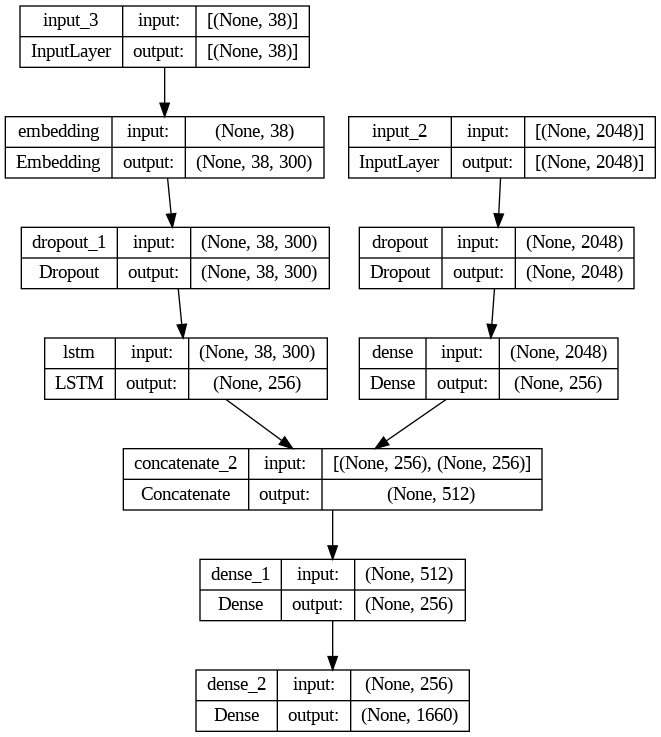

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
descriptions_test = {'2094810449_f8df9dcdf7': ['a boy stands in the ocean lifting up his shorts ',
  'a child in blue shorts is standing ankle deep in the water ',
  'a little boy in blue shorts  glasses  and a coat stands in the surf ',
  'the kid is wearing a blue jacket and standing in shallow beach water ',
  'the small child wades ankle deep in the water on the shoreline ']}

In [ ]:
descriptions_test.items()

dict_items([('2094810449_f8df9dcdf7', ['a boy stands in the ocean lifting up his shorts ', 'a child in blue shorts is standing ankle deep in the water ', 'a little boy in blue shorts  glasses  and a coat stands in the surf ', 'the kid is wearing a blue jacket and standing in shallow beach water ', 'the small child wades ankle deep in the water on the shoreline '])])

In [ ]:
for key, desc_list in tqdm(descriptions_test.items()):
            # retrieve the photo feature
            for desc in desc_list:
                # encode the sequence
                print(desc)
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                print("Sewquence = ")
                print(seq)
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    print('in_seq = ')
                    print(in_seq)
                    # encode output sequence
                    print("out_seq_before = ",out_seq)
                    num = out_seq
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    print('out_seq = ')
                    print(out_seq)
                    print("At Sequence ",num," = ", out_seq[num])
                    print("Size of the Sequence  = ", len(out_seq))
                    # store



100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

a boy stands in the ocean lifting up his shorts 
Sewquence = 
[2, 132, 124, 4, 22, 340, 9, 74, 391]
in_seq = 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2]
out_seq_before =  132
out_seq = 
[0. 0. 0. ... 0. 0. 0.]
At Sequence  132  =  1.0
Size of the Sequence  =  1660
in_seq = 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   2 132]
out_seq_before =  124
out_seq = 
[0. 0. 0. ... 0. 0. 0.]
At Sequence  124  =  1.0
Size of the Sequence  =  1660
in_seq = 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2
 132 124]
out_seq_before =  4
out_seq = 
[0. 0. 0. ... 0. 0. 0.]
At Sequence  4  =  1.0
Size of the Sequence  =  1660
in_seq = 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

In [ ]:

=> output => [1,2,3,4]

output layer

4 neurons

1 0 0 0 - 1

0 1 0 0 - 2

0 0 1 0 - 3

0 0 0 1 - 4





In [ ]:
4 words (38)

output = 10 = vocabulary (1660)

caption - 4 3 2 0


Generator - 0 0 0 0 - Input - Input - Photo(2048)

0 0 0 0 1 0 0 0 0 0 0 - Output - 4

Generator - 0 0 0 4 - Input - Photo(2048)

0 0 0 1 0 0 0 0 0 0 0 - Output - 3

Generator - 0 0 4 3 - Input - Photo(2048)

0 0 1 0 0 0 0 0 0 0 0 - Output - 2

Generator - 0 4 3 2 - Input - Photo(2048)

1 0 0 0 0 0 0 0 0 0 0 - Output - 0

Final Output  - 4 3 2 0























In [ ]:
in_seq

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  22,  61,   3, 571, 495,   4,  22, 127,  36,  22],
      dtype=int32)

In [ ]:
out_seq.shape

(1660,)

In [ ]:
train_features['397601572_9587a39291.jpg'].shape

(2048,)

In [ ]:
descriptions_test.items()

dict_items([('2094810449_f8df9dcdf7', ['a boy stands in the ocean lifting up his shorts ', 'a child in blue shorts is standing ankle deep in the water ', 'a little boy in blue shorts  glasses  and a coat stands in the surf ', 'the kid is wearing a blue jacket and standing in shallow beach water ', 'the small child wades ankle deep in the water on the shoreline '])])

In [ ]:
descriptions

In [ ]:
train_features.keys()

dict_keys(['397601572_9587a39291.jpg', '407678652_1f475acd65.jpg', '431410325_f4916b5460.jpg', '437527058_189f2a7eef.jpg', '404216567_75b50b5a36.jpg', '407569668_19b3f8eaf6.jpg', '432496659_f01464d9fb.jpg', '428485639_a82635d6ee.jpg', '413737417_b0a8b445e9.jpg', '418667611_b9995000f4.jpg'])

In [ ]:
desc_slice_test = {}
for i in train_features.keys():
  print(descriptions[str(i).split('.')[0]])
  desc_slice_test[str(i).split('.')[0]] = descriptions[str(i).split('.')[0]]

['the back of two men s heads riding on a train ', 'the backs of the heads of two men that are plugging their ears while riding the subway ', 'two guys are sharing headphones and are listening to music on a subway ', 'two men on a busy subway  seen from behind ', 'two people sitting together on a subway listening to earphones ']
['a group of hikers climb rocky terrain ', 'five backpackers hiking along a rocky slope ', 'five hikers walk down the hillside ', 'five people with backpacks hiking down a rocky hill ', 'the hikers descend on the mountain ']
['a golden haired dog with wet hair is licking its nose while moving through shallow water ', 'a golden retriever licks his nose as he dries off from the water ', 'a long haired dog walks out of the water and licks his nose ', 'a wet brown dog is leaving the water ', 'the brown dog is running in the water licking his nose ']
['a caravan of snowmobile travel through the snow ', 'a pair of people in heavy winter jackets rides through the snow

In [ ]:
desc_slice_test

{'397601572_9587a39291': ['the back of two men s heads riding on a train ',
  'the backs of the heads of two men that are plugging their ears while riding the subway ',
  'two guys are sharing headphones and are listening to music on a subway ',
  'two men on a busy subway  seen from behind ',
  'two people sitting together on a subway listening to earphones '],
 '407678652_1f475acd65': ['a group of hikers climb rocky terrain ',
  'five backpackers hiking along a rocky slope ',
  'five hikers walk down the hillside ',
  'five people with backpacks hiking down a rocky hill ',
  'the hikers descend on the mountain '],
 '431410325_f4916b5460': ['a golden haired dog with wet hair is licking its nose while moving through shallow water ',
  'a golden retriever licks his nose as he dries off from the water ',
  'a long haired dog walks out of the water and licks his nose ',
  'a wet brown dog is leaving the water ',
  'the brown dog is running in the water licking his nose '],
 '437527058_189

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    print()

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
max_length

38

In [ ]:
epochs = 3
batch_size = 100
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=2)

KeyError: '1000268201_693b08cb0e.jpg'

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        print(photo)
        print(len(photo[0]))
        print(sequence)

        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        print(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

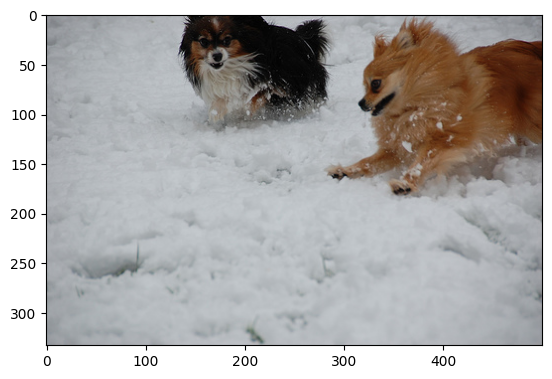

[[0.14477947 0.14842927 0.13912193 ... 0.7552172  0.07503608 0.12203263]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]]
2
[[0.14477947 0.14842927 0.13912193 ... 0.7552172  0.07503608 0.12203263]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 2]]
26
[[0.14477947 0.14842927 0.13912193 ... 0.7552172  0.07503608 0.12203263]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  1  2 26]]
7
[[0.14477947 0.14842927 0.13912193 ... 0.7552172  0.07503608 0.12203263]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  1  2 26  7]]
106
[[0.14477947 0.14842927 0.13912193 ... 0.7552172  0.07503608 0.12203263]]
2048
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2  26
    7 106]]
111
[[0.14477947 0.14842927 0.

In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
#print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
#print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
#print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
#print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
ixtoword

{1: 'startseq',
 2: 'a',
 3: 'child',
 4: 'in',
 5: 'pink',
 6: 'dress',
 7: 'is',
 8: 'climbing',
 9: 'up',
 10: 'set',
 11: 'of',
 12: 'stairs',
 13: 'an',
 14: 'way',
 15: 'endseq',
 16: 'girl',
 17: 'going',
 18: 'into',
 19: 'wooden',
 20: 'building',
 21: 'little',
 22: 'the',
 23: 'to',
 24: 'her',
 25: 'black',
 26: 'dog',
 27: 'and',
 28: 'spotted',
 29: 'are',
 30: 'fighting',
 31: 'tricolored',
 32: 'playing',
 33: 'with',
 34: 'each',
 35: 'other',
 36: 'on',
 37: 'road',
 38: 'white',
 39: 'brown',
 40: 'spots',
 41: 'staring',
 42: 'at',
 43: 'street',
 44: 'two',
 45: 'dogs',
 46: 'different',
 47: 'looking',
 48: 'pavement',
 49: 'moving',
 50: 'toward',
 51: 'covered',
 52: 'paint',
 53: 'sits',
 54: 'front',
 55: 'painted',
 56: 'rainbow',
 57: 'hands',
 58: 'bowl',
 59: 'sitting',
 60: 'large',
 61: 'small',
 62: 'grass',
 63: 'plays',
 64: 'it',
 65: 'there',
 66: 'pigtails',
 67: 'painting',
 68: 'young',
 69: 'outside',
 70: 'man',
 71: 'lays',
 72: 'bench',
 73: 

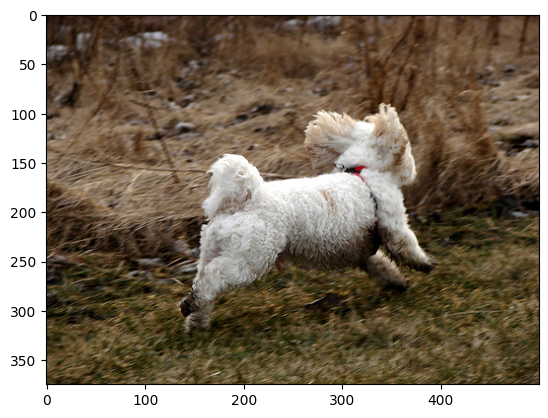

[[0.14646423 0.20388085 0.11236641 ... 1.1507863  0.0849223  0.03618722]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]]
2
[[0.14646423 0.20388085 0.11236641 ... 1.1507863  0.0849223  0.03618722]]
2048
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 2]]
26
[[0.14646423 0.20388085 0.11236641 ... 1.1507863  0.0849223  0.03618722]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  1  2 26]]
7
[[0.14646423 0.20388085 0.11236641 ... 1.1507863  0.0849223  0.03618722]]
2048
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  1  2 26  7]]
106
[[0.14646423 0.20388085 0.11236641 ... 1.1507863  0.0849223  0.03618722]]
2048
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2  26
    7 106]]
111
[[0.14646423 0.20388085 0.

In [ ]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
#print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
#print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
#print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))